# Постановка задачи
Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Дополнительные пояснения
- Целевым параметром (таргет) будет считаться конечная (последняя) температура
- `bulk_time` и `wire_time` некорректные из-за сбоя
- считаем что все нагревы (arc) были между первой и последними замерами температуры, даже если по времени они не попадают в указанный интервал согласно таблице temp
- пропуски с присадками - нули
- если данных по газу по партии вообще нет - удаляем
- если данных по присадкам (ИЛИ присыпку ИЛИ проволоку) по партии вообще нет, то удаляем
- метрика MAE
- выборку test сделать 20%


# План работ  
- Провести исследовательский анализ данных:
    - Подготовить данные: заполнить пропуски нулями, переименовать столбцы, привести столбцы в корректный формат
    - Посмотреть на распределение исходных данных
    - Проанализировать порядок событий в производственном процессе
    - Подготовить дополнительные поля
    - Подготовить таблицу сводную по партиям (одна строка = одна партия)
    - Исключить партии, которые не имеют последнего замера температуры, либо первый замер соответствует последнему, либо замеры отсутствуют
- Подобрать признаки, на которых будет обучаться модель:
    - Сгенерировать ряд признаков
    - Проверить признаки на мультиколлинеарность, исключить лишние
- Построить модель, которая предскажет температуру стали:
    - Сформировать обучающую train и тестовую test выборки
    - Подготовить процедуру подбора лучшей по метрике MAE модели и для нее лучших гиперпараметров на нескольких моделях
     - Провести масштабирование признаков
     - Выбрать лучшую модель и оптимальные параметры OPTUNA c CrossValidation
     - Провести анализ на train с CrossValidation значимости фичей и оставить только значимые
    - Эффективность лучшей модели проверить на тестовой выборке
    - Построить диаграмму SHAP значимости фичей на тестовой выборке

# Обзор

## Загрузка библиотек

In [1]:
# pip install lightgbm

In [2]:
# pip install catboost

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime as dt
import numpy as np
import seaborn as sns
import optuna
import lightgbm as lgb
# from catboost import cv, Pool
# from catboost import CatBoostRegressor


from imblearn.pipeline import Pipeline, make_pipeline
from imblearn import FunctionSampler

from pylab import rcParams
# from matplotlib.gridspec import GridSpec

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.impute import KNNImputer

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import (
    LinearRegression, 
    LogisticRegression, 
    HuberRegressor, 
    PassiveAggressiveRegressor,
    ARDRegression, 
    BayesianRidge, 
    SGDRegressor, 
    ElasticNet)
from sklearn.ensemble import (
   RandomForestRegressor, 
   GradientBoostingRegressor, 
   BaggingRegressor,
   HistGradientBoostingRegressor,
   AdaBoostRegressor)


# from scipy import stats as st
from numpy.random import RandomState
from matplotlib import style

import shap
from BorutaShap import BorutaShap

In [4]:
print(dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

rcParams['figure.figsize'] = (12, 8)

pd.options.display.float_format = '{:,.3f}'.format
pd.options.display.max_columns = 100
pd.set_option('display.max_rows', 100)
pd.options.mode.chained_assignment = None

plt.rcParams['image.cmap'] = 'Set2'
plt.set_cmap("Set2");

sns.set_style("whitegrid", {'figure.facecolor': '0.97'});
sns.set_palette("Set2");
style.use('dark_background')

RANDOM_STATE = 29082022

2022-09-03 17:07:04


<Figure size 864x576 with 0 Axes>

## Пользовательские функции

In [5]:
def corr_triag_heatmap(corr, title_str):
#     ======
#     Функция для построения треугольной матрицы heatmap без диагональных элементов
#     corr - таблица корреляций
#     title_str - название графика
#     ======

    
    # mask = np.zeros_like(corr)
    # mask[np.triu_indices_from(mask)] = True
    mask = np.triu(np.full(corr.shape, True))
    corr = corr.iloc[1:, :-1]
    mask = pd.DataFrame(mask).iloc[1:, :-1].to_numpy()

    # делаем heatmap
    plt.figure(figsize=(corr.shape[0] * 1.2, (corr.shape[0] * 0.6)))
    ax = sns.heatmap(corr, annot=True, cmap="RdBu", mask=mask, vmin=-1, vmax=1)
    ax.set_title(title_str, fontdict={'fontsize':14})
    plt.show()

# Определим функцию для изучения датасета, ее будем применять к разным датафреймам
def evaluate_df(df, show_corr_zero_plots = False, show_corr_null_plots=False, show_scatter_matrix=False):
#     ======
#     Функция для изучения датафрейма
#       sample
#       типы данных в столбцах
#       число пропусков и нулей
#       корреляция появления нулей синхронно в разных столбцах
#       корреляция появления пропусков синхронно в разных столбцах
#       матрицы scatterplot для всех пар столбцов + гистограммы
#     ======
    
    print('\n------SAMPLE--------')
    display(df.sample(min(5,len(df))))
    print('\n------DTYPES--------')
    print(df.dtypes)

    # число пропусков
    print('\n\n------NaN & zero--------')
    na = pd.DataFrame(index=df.columns
                      , data={
                          'NA':df.isna().sum().values
                          , 'filled': df.notna().sum().values
                          , 'zero':df.eq(0).sum()
                      }
                     )
    na['%na'] = na['NA']/len(df)*100
    print(na.replace(0,'-'))
    
    if show_corr_zero_plots:
        # готовим матрицу корреляций нулей
        t = df.isin([0,'0']).sum().sort_values()
        indx = t[t > 0].index
        if len(indx) > 1:
            print()
            corr = df[indx].isin([0,'0']).corr()
            corr_triag_heatmap(corr, "Correlation of ZEROs in columns")
            
            # Добавим карту синхронных нулей
            t = df[indx].isin([0,'0']).sort_values(by=list(indx))
            plt.figure(figsize = (20,len(indx)*0.6))
            
            ax = sns.heatmap(t.transpose(), alpha=0.4,cbar_kws = {"ticks":[False, True], "drawedges":True}, cmap=sns.color_palette(['#00AA00', '#FF4444']))
            ax.set_title("Map of ZEROs values", fontdict={'fontsize':14})
            ax.hlines(ax.yaxis.get_ticklocs() + 0.5, 0, t.shape[0], color='w', linewidths=1)
            plt.show()
    if show_corr_null_plots:
        # готовим матрицу корреляций нулей
        t = df.isna().sum().sort_values()
        indx = t[t > 0].index
        if len(indx) > 1:
            print()
            corr = df[indx].isna().corr()
            corr_triag_heatmap(corr, "Correlation of NULL in columns")
            
            # Добавим карту синхронных нулей
            t = df[indx].isna().sort_values(by=list(indx))
            plt.figure(figsize = (20,len(indx)*0.6))
            
            ax = sns.heatmap(t.transpose(), alpha=0.4,cbar_kws = {"ticks":[False, True], "drawedges":True}, cmap=sns.color_palette(['#00AA00', '#FF4444']))
            ax.set_title("Map of NULL values", fontdict={'fontsize':14})
            ax.hlines(ax.yaxis.get_ticklocs() + 0.5, 0, t.shape[0], color='w', linewidths=1)
            plt.show()

    # статистики
    display(df.describe(include='all').transpose())
    
    if show_scatter_matrix:
        pd.plotting.scatter_matrix(df, figsize=(16,10), alpha=0.1, s=5);

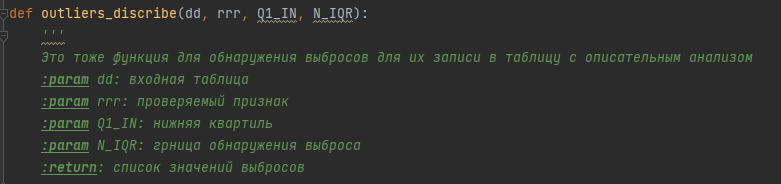

## Загрузка данных

In [6]:
try:
    df_arc = pd.read_csv('/datasets/final_steel/data_arc.csv', sep=',', parse_dates=[1,2])
    df_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv', sep=',')
    df_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv', sep=',', parse_dates=list(range(1,16)))
    df_gas = pd.read_csv('/datasets/final_steel/data_gas.csv', sep=',')
    df_temp = pd.read_csv('/datasets/final_steel/data_temp.csv', sep=',', parse_dates=[1])
    df_wire = pd.read_csv('/datasets/final_steel/data_wire.csv', sep=',')
    df_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv', sep=',', parse_dates=list(range(1,10)))
    
except:    
    df_arc = pd.read_csv('datasets\\final_project\\data_arc.csv', sep=',', parse_dates=[1,2])
    df_bulk = pd.read_csv('datasets\\final_project\\data_bulk.csv', sep=',')
    df_bulk_time = pd.read_csv('datasets\\final_project\\data_bulk_time.csv', sep=',', parse_dates=list(range(1,16)))
    df_gas = pd.read_csv('datasets\\final_project\\\data_gas.csv', sep=',')
    df_temp = pd.read_csv('datasets\\final_project\\data_temp.csv', sep=',', parse_dates=[1])
    df_wire = pd.read_csv('datasets\\final_project\\data_wire.csv', sep=',')
    df_wire_time = pd.read_csv('datasets\\final_project\\data_wire_time.csv', sep=',', parse_dates=list(range(1,10)))


## Переименование столбцов

In [7]:
# Делаем сводный словарь фреймов
df_all = {
            'arc': df_arc,
            'bulk':df_bulk,
            'bulk_time':df_bulk_time,
            'gas': df_gas,
            'temp':df_temp,
            'wire':df_wire,
            'wire_time':df_wire_time
         }

In [8]:
# Смотрим названия столбцов
for name, df_ in df_all.items():
    print(name)
    print(list(df_.columns))

arc
['key', 'Начало нагрева дугой', 'Конец нагрева дугой', 'Активная мощность', 'Реактивная мощность']
bulk
['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']
bulk_time
['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']
gas
['key', 'Газ 1']
temp
['key', 'Время замера', 'Температура']
wire
['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']
wire_time
['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']


In [9]:
# Переименовываем
df_arc.columns = ['key', 'heating_start', 'heating_end', 'active_power', 'reactive_power']
df_bulk.columns = [v.replace(' ','_') for v in  df_bulk.columns]
df_bulk_time.columns = [v.replace(' ','_') for v in  df_bulk_time.columns]
df_gas.columns = ['key', 'gas']
df_temp.columns = ['key', 'datetime', 'temperature']
df_wire.columns = [v.replace(' ','_') for v in  df_wire.columns]
df_wire_time.columns = [v.replace(' ','_') for v in  df_wire_time.columns]

# Делаем сводный словарь фреймов
df_all = {
            'arc': df_arc,
            'bulk':df_bulk,
            'bulk_time':df_bulk_time,
            'gas': df_gas,
            'temp':df_temp,
            'wire':df_wire,
            'wire_time':df_wire_time
         }

In [10]:
# Проверяем результат переименования
for name, df_ in df_all.items():
    print(name)
    print(list(df_.columns))

arc
['key', 'heating_start', 'heating_end', 'active_power', 'reactive_power']
bulk
['key', 'Bulk_1', 'Bulk_2', 'Bulk_3', 'Bulk_4', 'Bulk_5', 'Bulk_6', 'Bulk_7', 'Bulk_8', 'Bulk_9', 'Bulk_10', 'Bulk_11', 'Bulk_12', 'Bulk_13', 'Bulk_14', 'Bulk_15']
bulk_time
['key', 'Bulk_1', 'Bulk_2', 'Bulk_3', 'Bulk_4', 'Bulk_5', 'Bulk_6', 'Bulk_7', 'Bulk_8', 'Bulk_9', 'Bulk_10', 'Bulk_11', 'Bulk_12', 'Bulk_13', 'Bulk_14', 'Bulk_15']
gas
['key', 'gas']
temp
['key', 'datetime', 'temperature']
wire
['key', 'Wire_1', 'Wire_2', 'Wire_3', 'Wire_4', 'Wire_5', 'Wire_6', 'Wire_7', 'Wire_8', 'Wire_9']
wire_time
['key', 'Wire_1', 'Wire_2', 'Wire_3', 'Wire_4', 'Wire_5', 'Wire_6', 'Wire_7', 'Wire_8', 'Wire_9']


## Обзор фреймов

In [11]:
# Проверяем наличие дубликатов
print('---   Дубликаты строк  ---')
for name, df_ in df_all.items():
    print(name, df_.duplicated(subset=None, keep='first').sum())

---   Дубликаты строк  ---
arc 0
bulk 0
bulk_time 0
gas 0
temp 0
wire 0
wire_time 0


Дубликатов нет, это хорошо. Идем дальше

### df_arc

In [12]:
name = 'arc'
df_ = df_all[name]
print('==========   df_' + name, '   ===========')
evaluate_df(df_)

==========   df_arc    ===========

------SAMPLE--------


,key,heating_start,heating_end,active_power,reactive_power
3515,761,2019-05-31 17:48:10,2019-05-31 17:50:30,0.587,0.394
5095,1104,2019-06-12 16:15:08,2019-06-12 16:16:59,0.427,0.325
12215,2653,2019-08-11 15:51:13,2019-08-11 15:52:04,0.190,0.130
12577,2732,2019-08-14 07:27:35,2019-08-14 07:31:22,0.754,0.666
1051,228,2019-05-11 19:43:37,2019-05-11 19:45:38,0.414,0.324



------DTYPES--------
key                        int64
heating_start     datetime64[ns]
heating_end       datetime64[ns]
active_power             float64
reactive_power           float64
dtype: object


------NaN & zero--------
               NA  filled zero %na
key             -   14876    -   -
heating_start   -   14876    -   -
heating_end     -   14876    -   -
active_power    -   14876    -   -
reactive_power  -   14876    -   -


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
key,"14,876.000",NaN,NaT,NaN,NaT,NaT,"1,615.220",934.572,1.000,806.000,"1,617.000","2,429.000","3,241.000"
heating_start,14876,14875,2019-06-10 22:02:03,2,2019-05-03 11:02:14,2019-09-01 04:34:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN
heating_end,14876,14876,2019-05-03 11:06:02,1,2019-05-03 11:06:02,2019-09-01 04:36:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
active_power,"14,876.000",NaN,NaT,NaN,NaT,NaT,0.670,0.408,0.030,0.395,0.556,0.857,3.732
reactive_power,"14,876.000",NaN,NaT,NaN,NaT,NaT,0.453,5.879,-715.505,0.291,0.416,0.637,2.676


<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА</b></u></p>
    <p>ЭТУ КОМАНДУ МОЖНО ИСПОЛЬЗОВАТЬ ДЛЯ ФИЛЬТРА ПРЕДУПРЕЖДЕНИЙ.<br>
import warnings<br>
warnings.filterwarnings('ignore')</p>

<div class="alert alert-block alert-info"  style="background-color: #D1C4E9; color:#4A148C; border-color:#7E57C2">
<b>Комментарий студента:</b><br>

Да, но я наоборот люблю читать предупреждения такие, они иногда полезны

</div>

 <div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <font color='green'> <b><u>КОММЕНТАРИЙ ТИМЛИДА 2</u></b><br><br>ОК, понял, аргумент))

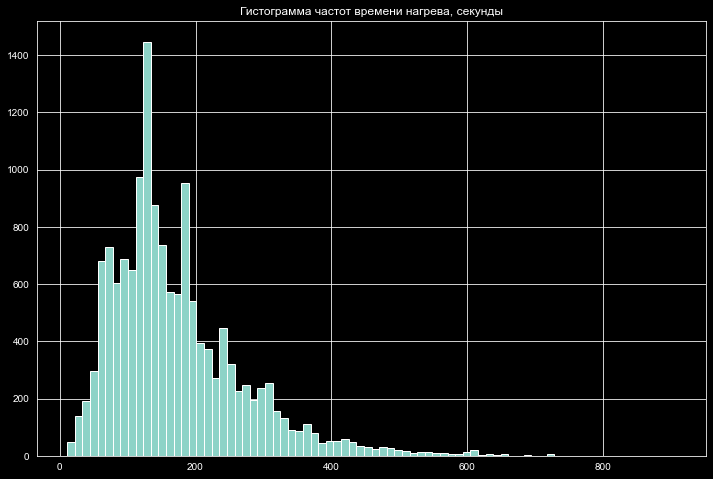

In [13]:
t = (df_['heating_end'] - df_['heating_start']).dt.seconds
ax = t.hist(bins=80)
ax.set_title('Гистограмма частот времени нагрева, секунды');

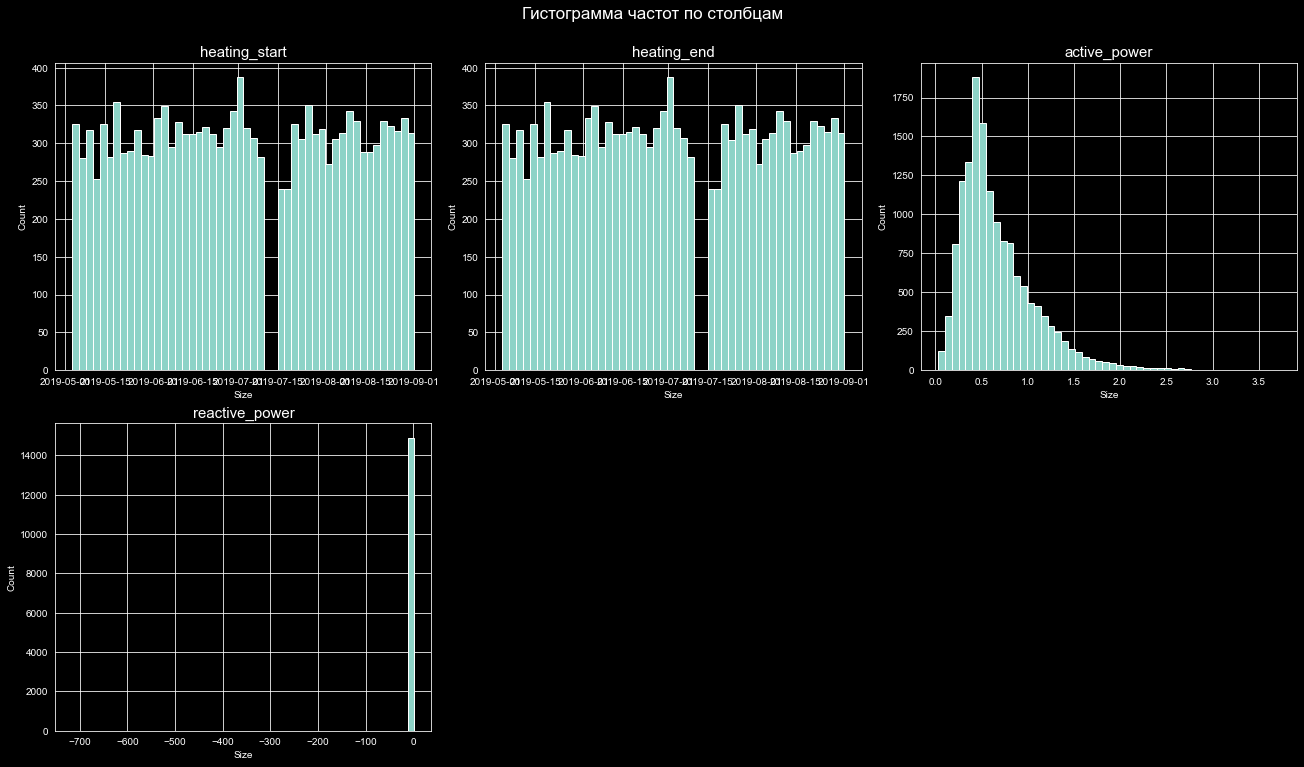

In [14]:
fig = plt.figure(constrained_layout=True, figsize=(18,10))


i = 0
for col in df_.columns[1:]:
    i += 1
    ax = plt.subplot(2, 3, i)
    df_[col].hist(bins=50, ax=ax)
    ax.set_title(col, fontsize=15);
    ax.set(xlabel="Size", ylabel="Count")
#    plt.show()
    
fig.suptitle("Гистограмма частот по столбцам", fontsize=17, y=1.05);

In [15]:
# Аномалия в реактивной мощности
df_arc.query('reactive_power < 0')

,key,heating_start,heating_end,active_power,reactive_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.496,-715.505


Как видим, выброс исказил гистограмму. Построим гистограмму только по положительным значениям

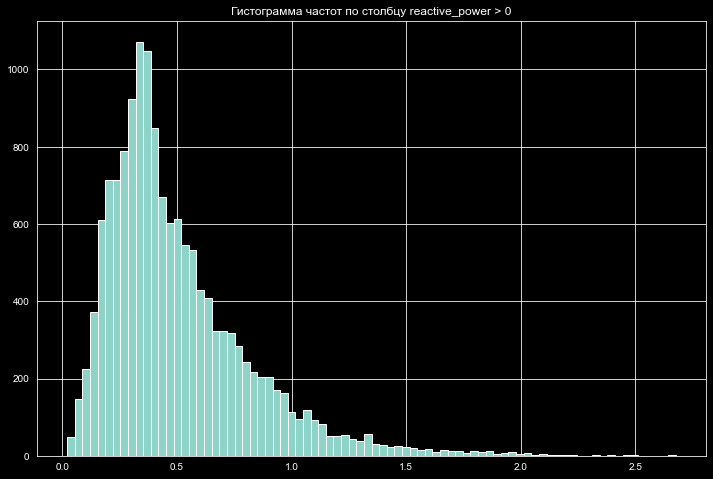

In [16]:
col = 'reactive_power'
ax = df_[df_[col] >= 0][col].hist(bins=80)
ax.set_title('Гистограмма частот по столбцу '+col + ' > 0');
plt.show()

### df_bulk

In [17]:
name = 'bulk'
df_ = df_all[name]
print('==========   df_' + name, '   ===========')
evaluate_df(df_)

==========   df_bulk    ===========

------SAMPLE--------


,key,Bulk_1,Bulk_2,Bulk_3,Bulk_4,Bulk_5,Bulk_6,Bulk_7,Bulk_8,Bulk_9,Bulk_10,Bulk_11,Bulk_12,Bulk_13,Bulk_14,Bulk_15
2405,2497,NaN,NaN,NaN,85.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,230.000,NaN,124.000,226.000
824,859,NaN,NaN,264.000,96.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,409.000,NaN,226.000,204.000
1787,1849,NaN,NaN,NaN,141.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.000,NaN,99.000,203.000
807,842,NaN,NaN,102.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.000,NaN,132.000,101.000
2707,2808,NaN,NaN,NaN,112.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158.000,NaN,102.000,108.000



------DTYPES--------
key          int64
Bulk_1     float64
Bulk_2     float64
Bulk_3     float64
Bulk_4     float64
Bulk_5     float64
Bulk_6     float64
Bulk_7     float64
Bulk_8     float64
Bulk_9     float64
Bulk_10    float64
Bulk_11    float64
Bulk_12    float64
Bulk_13    float64
Bulk_14    float64
Bulk_15    float64
dtype: object


------NaN & zero--------
           NA  filled zero    %na
key         -    3129    -      -
Bulk_1   2877     252    - 91.946
Bulk_2   3107      22    - 99.297
Bulk_3   1831    1298    - 58.517
Bulk_4   2115    1014    - 67.593
Bulk_5   3052      77    - 97.539
Bulk_6   2553     576    - 81.592
Bulk_7   3104      25    - 99.201
Bulk_8   3128       1    - 99.968
Bulk_9   3110      19    - 99.393
Bulk_10  2953     176    - 94.375
Bulk_11  2952     177    - 94.343
Bulk_12   679    2450    - 21.700
Bulk_13  3111      18    - 99.425
Bulk_14   323    2806    - 10.323
Bulk_15   881    2248    - 28.156


,count,mean,std,min,25%,50%,75%,max
key,"3,129.000","1,624.384",933.338,1.000,816.000,"1,622.000","2,431.000","3,241.000"
Bulk_1,252.000,39.242,18.278,10.000,27.000,31.000,46.000,185.000
Bulk_2,22.000,253.045,21.181,228.000,242.000,251.500,257.750,325.000
Bulk_3,"1,298.000",113.879,75.483,6.000,58.000,97.500,152.000,454.000
Bulk_4,"1,014.000",104.394,48.184,12.000,72.000,102.000,133.000,281.000
Bulk_5,77.000,107.026,81.791,11.000,70.000,86.000,132.000,603.000
Bulk_6,576.000,118.925,72.058,17.000,69.750,100.000,157.000,503.000
Bulk_7,25.000,305.600,191.023,47.000,155.000,298.000,406.000,772.000
Bulk_8,1.000,49.000,NaN,49.000,49.000,49.000,49.000,49.000
Bulk_9,19.000,76.316,21.721,63.000,66.000,68.000,70.500,147.000


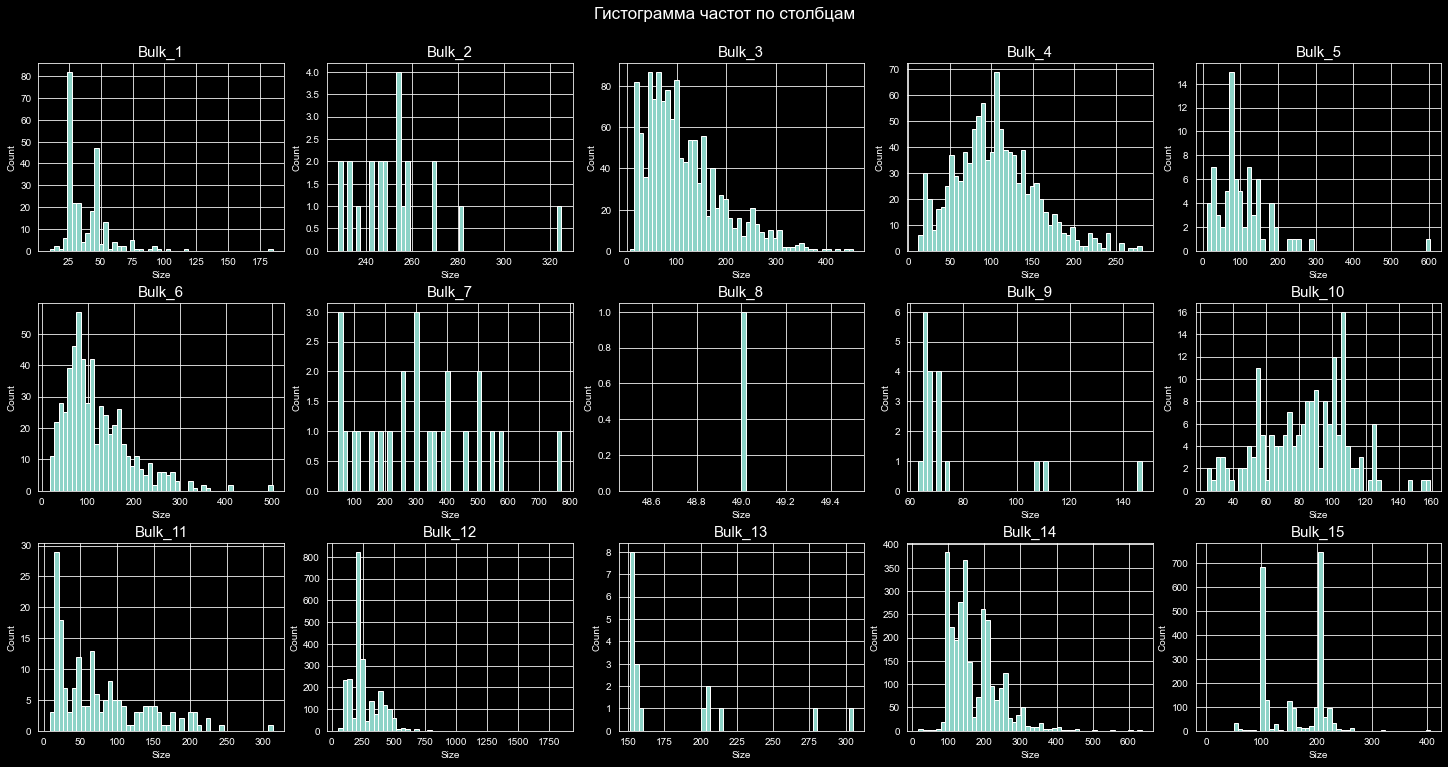

In [18]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))

i = 0
for col in df_.columns[1:]:
    i += 1
    ax = plt.subplot(3, 5, i)
    df_[col].hist(bins=50, ax=ax)
    ax.set_title(col, fontsize=15);
    ax.set(xlabel="Size", ylabel="Count")
#    plt.show()
    
fig.suptitle("Гистограмма частот по столбцам", fontsize=17, y=1.05);
    
    


<AxesSubplot:title={'center':'Число непустых значений'}>

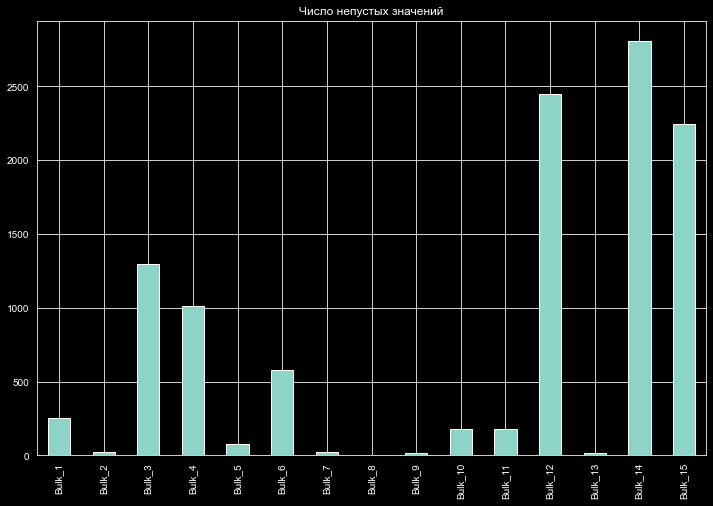

In [19]:
df_.count()[1:].plot(kind='bar', title='Число непустых значений')

### df_gas

In [20]:
name = 'gas'
df_ = df_all[name]
print('==========   df_' + name, '   ===========')
evaluate_df(df_)

==========   df_gas    ===========

------SAMPLE--------


,key,gas
1962,1965,16.306
2834,2837,9.203
1944,1947,1.735
1081,1084,8.051
1481,1484,9.606



------DTYPES--------
key      int64
gas    float64
dtype: object


------NaN & zero--------
    NA  filled zero %na
key  -    3239    -   -
gas  -    3239    -   -


,count,mean,std,min,25%,50%,75%,max
key,"3,239.000","1,621.861",935.386,1.000,812.500,"1,622.000","2,431.500","3,241.000"
gas,"3,239.000",11.002,6.220,0.008,7.043,9.836,13.770,77.995


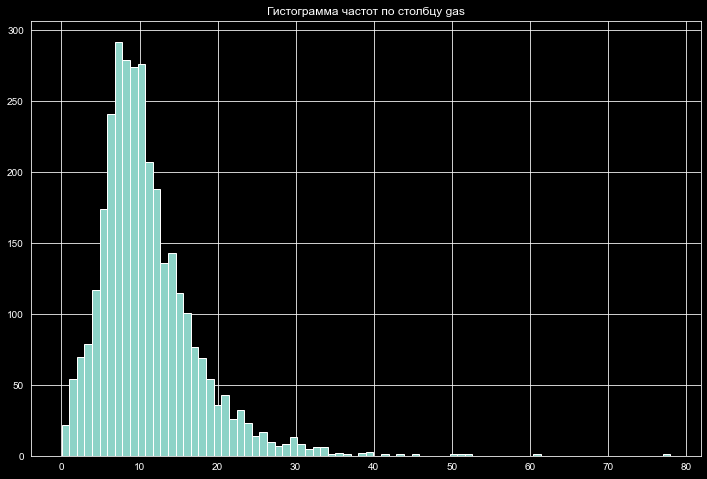

In [21]:
for col in df_.columns[1:]:
    ax = df_[col].hist(bins=80)
    ax.set_title('Гистограмма частот по столбцу '+col);
    plt.show()

### df_temp

In [22]:
name = 'temp'
df_ = df_all[name]
print('==========   df_' + name, '   ===========')
evaluate_df(df_)

==========   df_temp    ===========

------SAMPLE--------


,key,datetime,temperature
5659,1144,2019-06-14 02:31:00,"1,605.000"
1579,286,2019-05-14 03:24:38,"1,604.000"
6548,1325,2019-06-19 23:54:36,"1,594.000"
14217,2887,2019-08-20 03:56:43,"1,620.000"
1862,343,2019-05-16 04:37:43,"1,609.000"



------DTYPES--------
key                     int64
datetime       datetime64[ns]
temperature           float64
dtype: object


------NaN & zero--------
               NA  filled zero    %na
key             -   15907    -      -
datetime        -   15907    -      -
temperature  2901   13006    - 18.237


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
key,"15,907.000",NaN,NaT,NaN,NaT,NaT,"1,607.881",942.212,1.000,790.000,"1,618.000","2,427.000","3,241.000"
datetime,15907,15907,2019-05-03 11:16:18,1,2019-05-03 11:16:18,2019-09-01 04:38:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temperature,"13,006.000",NaN,NaT,NaN,NaT,NaT,"1,591.841",21.376,"1,191.000","1,581.000","1,591.000","1,601.000","1,705.000"


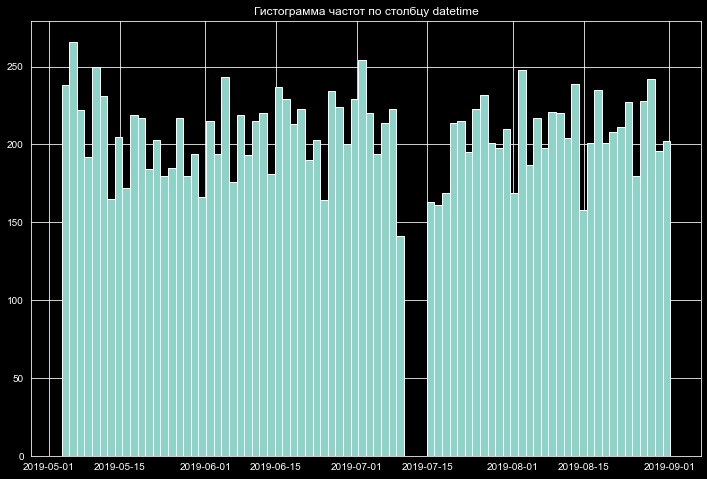

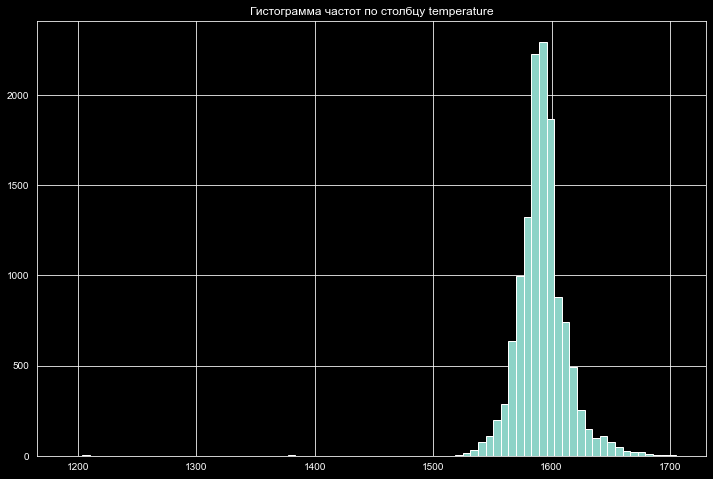

In [23]:
for col in df_.columns[1:]:
    ax = df_[col].hist(bins=80)
    ax.set_title('Гистограмма частот по столбцу '+col);
    plt.show()

Видно, что имеются аномалии слева. Вероятно это другой сплав, который плавится не при 1500, а при 1200

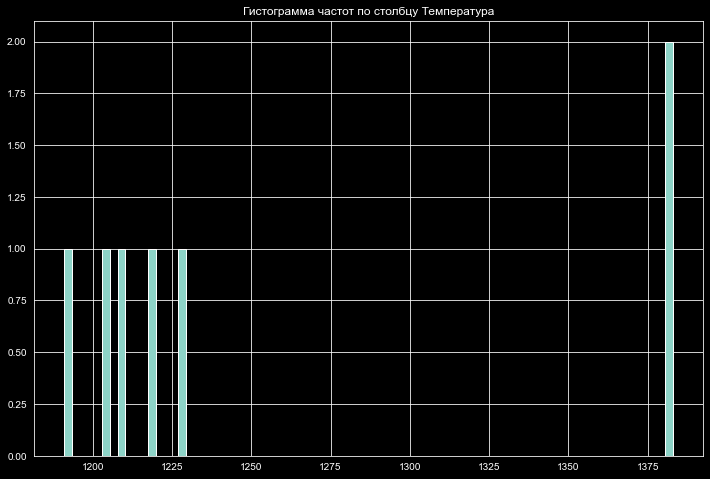

In [24]:
ax = df_.query('temperature < 1500')['temperature'].hist(bins=80)
ax.set_title('Гистограмма частот по столбцу Температура');
plt.show()

### df_wire

In [25]:
name = 'wire'
df_ = df_all[name]
print('==========   df_' + name, '   ===========')
evaluate_df(df_)

==========   df_wire    ===========

------SAMPLE--------


,key,Wire_1,Wire_2,Wire_3,Wire_4,Wire_5,Wire_6,Wire_7,Wire_8,Wire_9
2017,2115,35.075,NaN,NaN,NaN,NaN,15.066,NaN,NaN,NaN
710,757,145.361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139,155,93.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1238,1307,114.145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2436,2563,5.111,NaN,93.165,NaN,NaN,53.196,32.848,NaN,NaN



------DTYPES--------
key         int64
Wire_1    float64
Wire_2    float64
Wire_3    float64
Wire_4    float64
Wire_5    float64
Wire_6    float64
Wire_7    float64
Wire_8    float64
Wire_9    float64
dtype: object


------NaN & zero--------
          NA  filled zero    %na
key        -    3081    -      -
Wire_1    26    3055    -  0.844
Wire_2  2002    1079    - 64.979
Wire_3  3018      63    - 97.955
Wire_4  3067      14    - 99.546
Wire_5  3080       1    - 99.968
Wire_6  3008      73    - 97.631
Wire_7  3070      11    - 99.643
Wire_8  3062      19    - 99.383
Wire_9  3052      29    - 99.059


,count,mean,std,min,25%,50%,75%,max
key,"3,081.000","1,623.426",932.997,1.000,823.000,"1,619.000","2,434.000","3,241.000"
Wire_1,"3,055.000",100.896,42.013,1.919,72.116,100.158,126.060,330.314
Wire_2,"1,079.000",50.577,39.320,0.030,20.194,40.143,70.228,282.780
Wire_3,63.000,189.483,99.513,0.144,95.135,235.195,276.252,385.009
Wire_4,14.000,57.443,28.825,24.149,40.807,45.234,76.125,113.231
Wire_5,1.000,15.132,NaN,15.132,15.132,15.132,15.132,15.132
Wire_6,73.000,48.017,33.920,0.034,25.054,42.076,64.213,180.455
Wire_7,11.000,10.039,8.611,0.234,6.763,9.017,11.886,32.848
Wire_8,19.000,53.625,16.882,45.077,46.095,46.280,48.090,102.762
Wire_9,29.000,34.156,19.932,4.623,22.058,30.066,43.862,90.054


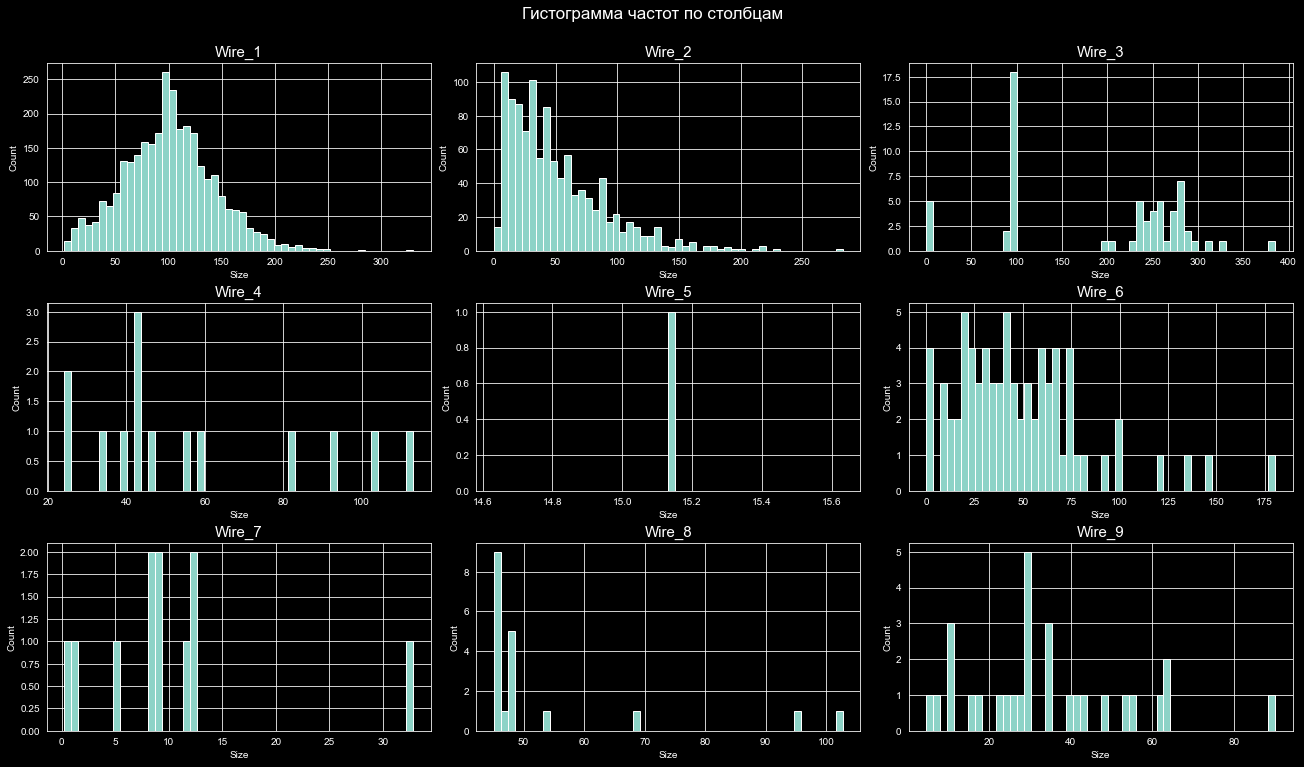

In [26]:
fig = plt.figure(constrained_layout=True, figsize=(18,10))


i = 0
for col in df_.columns[1:]:
    i += 1
    ax = plt.subplot(3, 3, i)
    df_[col].hist(bins=50, ax=ax)
    ax.set_title(col, fontsize=15);
    ax.set(xlabel="Size", ylabel="Count")
#    plt.show()
    
fig.suptitle("Гистограмма частот по столбцам", fontsize=17, y=1.05);

### Число уникальных партий

In [27]:
# Смотрим на число партий уникальных

def highlight_cells(val, color_if_true, color_if_false):
#     ======
#     Функция условного форматирования таблицы
#     ======
    color = color_if_true if val ==1 else color_if_false
    return 'background-color: {}'.format(color)

tbl = []
for name, df_ in df_all.items():
    cnt_unique = df_['key'].unique().shape[0]
    tbl.append(['df_' + name, df_.shape[0], cnt_unique, cnt_unique/df_.shape[0]])
    # print('df_' + name, 'всего партий(строк):', df_.shape[0], ', \tуникальных:', cnt_unique, ', \tдоля:', cnt_unique/df_.shape[0])
df_tbl = pd.DataFrame(data=tbl, columns=['frame', 'total', 'unique', 'frac'])
df_tbl.style.applymap(highlight_cells, color_if_true='#559955', color_if_false=None, 
                  subset=['frac'])
    

,frame,total,unique,frac
0,df_arc,14876,3214,0.216053
1,df_bulk,3129,3129,1.000000
2,df_bulk_time,3129,3129,1.000000
3,df_gas,3239,3239,1.000000
4,df_temp,15907,3216,0.202175
5,df_wire,3081,3081,1.000000
6,df_wire_time,3081,3081,1.000000


## Выводы

- Названия столбцов с пробелами с кириллице. Переименованы
- Имеются аномалии
  - отрицательное значение reactive_power
  - замеры расплава ниже температуры плавления temperature < 1400
- во фреймах arc и temp одно и то же значение key встречается в нескольких строках
 

# Подготовка данных

## Дополнительные поля

Добавим в фрейм следующие расчетные поля, они будут фичами для модели

1. Полная мощность
2. Активная энергия за нагрев
3. Реактивная энергия за нагрев
4. Полная энергия за нагрев
5. Время нагрева

In [28]:
df_arc['heating_time'] = (df_arc['heating_end'] - df_arc['heating_start']).dt.seconds
df_arc['full_power'] = (df_arc['active_power']**2 + df_arc['reactive_power']**2)**0.5
df_arc['active_energy'] = df_arc['active_power'] * df_arc['heating_time']
df_arc['reactive_energy'] = df_arc['reactive_power'] * df_arc['heating_time']
df_arc['full_energy'] = df_arc['full_power'] * df_arc['heating_time']
df_arc

,key,heating_start,heating_end,active_power,reactive_power,heating_time,full_power,active_energy,reactive_energy,full_energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976,0.687,228,1.194,222.541,156.655,272.150
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.806,0.520,185,0.959,149.037,96.253,177.417
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744,0.499,172,0.896,128.031,85.795,154.119
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659,1.063,365,1.970,605.667,387.874,719.221
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.693,0.414,148,0.807,102.528,61.331,119.471
...,...,...,...,...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.534,0.354,157,0.641,83.786,55.647,100.582
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.677,0.524,180,0.856,121.789,94.254,154.001
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.734,0.476,184,0.875,135.038,87.520,160.919
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.221,0.146,57,0.264,12.580,8.309,15.076


## подготовка фрейма с таргетом и фичами

Создаем фичи для модели:

1. Суммарная активная энергия
2. Суммарная полная энергия (полная мощность * время)
3. Число нагревов
4. Начальная температура
5. Время между первым замеров и последним замером температуры
6. Сумма времен нагревов
7. Среднее время нагрева
8. Средняя мощность активная
9. максимальная мощность активная
10. Средняя мощность полная
11. Максимальная мощность полная
12. Минимальная мощность активная
13. Минимальная пощность полная
14. 1/[5]
16. Компоненты Bulk
17. Компоненты wire
18. Среднее соотношение активной и пассивной мощностей

In [29]:
df_arc['active_reactive_rate'] = df_arc['active_power'] / df_arc['reactive_power']
df_arc_grouped = df_arc.sort_values(by=['key', 'heating_start', 'heating_end']).groupby(by='key', as_index=False).agg({
    'heating_time': ['sum', 'mean', 'count'], 
    'active_energy': ['sum', 'mean'],
    'reactive_energy': ['sum', 'mean'], 
    'full_energy': ['sum', 'mean'],
    'active_power': ['mean', 'median', 'min', 'max'],
    'reactive_power': ['mean', 'median', 'min', 'max'],
    'full_power': ['mean', 'median', 'min', 'max'],
    'active_reactive_rate':['mean']
})
df_arc_grouped.columns = ['_'.join(col) for col in df_arc_grouped.columns.values]
df_arc_grouped.rename(columns={'key_':'key'}, inplace=True)
df_arc_grouped['active_reactive_energy_rate_mean'] = df_arc_grouped['active_energy_sum']/df_arc_grouped['reactive_energy_sum']

df_arc_grouped

,key,heating_time_sum,heating_time_mean,heating_time_count,active_energy_sum,active_energy_mean,reactive_energy_sum,reactive_energy_mean,full_energy_sum,full_energy_mean,active_power_mean,active_power_median,active_power_min,active_power_max,reactive_power_mean,reactive_power_median,reactive_power_min,reactive_power_max,full_power_mean,full_power_median,full_power_min,full_power_max,active_reactive_rate_mean,active_reactive_energy_rate_mean
0,1,1098,219.600,5,"1,207.804",241.561,787.908,157.582,"1,442.378",288.476,0.976,0.806,0.693,1.659,0.637,0.520,0.414,1.063,1.165,0.959,0.807,1.970,1.539,1.533
1,2,811,202.750,4,733.816,183.454,487.591,121.898,881.234,220.308,0.763,0.659,0.438,1.296,0.500,0.411,0.283,0.893,0.912,0.777,0.522,1.574,1.552,1.505
2,3,655,131.000,5,443.583,88.717,280.937,56.187,525.067,105.013,0.505,0.429,0.250,1.062,0.320,0.272,0.156,0.671,0.598,0.508,0.295,1.257,1.583,1.579
3,4,741,185.250,4,670.663,167.666,429.936,107.484,796.911,199.228,0.802,0.781,0.426,1.221,0.515,0.519,0.268,0.755,0.954,0.938,0.503,1.435,1.563,1.560
4,5,869,217.250,4,997.496,249.374,664.940,166.235,"1,199.138",299.784,0.837,0.729,0.267,1.622,0.563,0.511,0.182,1.048,1.009,0.891,0.324,1.931,1.480,1.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,3237,909,181.800,5,777.993,155.599,559.334,111.867,958.336,191.667,0.786,0.802,0.406,1.060,0.566,0.555,0.320,0.785,0.969,0.975,0.517,1.319,1.384,1.391
3210,3238,546,182.000,3,432.849,144.283,348.343,116.114,555.867,185.289,0.702,0.718,0.372,1.017,0.560,0.521,0.310,0.851,0.899,0.887,0.484,1.326,1.258,1.243
3211,3239,1216,152.000,8,844.977,105.622,557.965,69.746,"1,013.068",126.633,0.583,0.500,0.206,1.157,0.389,0.361,0.135,0.725,0.701,0.617,0.246,1.365,1.498,1.514
3212,3240,839,167.800,5,554.283,110.857,471.604,94.321,729.209,145.842,0.597,0.522,0.412,0.984,0.497,0.417,0.274,0.885,0.778,0.689,0.495,1.323,1.257,1.175


In [30]:
df_temp_grouped = df_temp.fillna(-1).sort_values(by=['key', 'datetime']).groupby(by='key', as_index=False).agg({
    'datetime': ['first', 'last', 'count'],
    'temperature':  ['first', 'last'],
})
df_temp_grouped.columns = ['_'.join(col) for col in df_temp_grouped.columns.values]
df_temp_grouped.rename(columns={'key_':'key'}, inplace=True)
df_temp_grouped.replace({'temperature_last': {-1: np.nan}, 'temperature_first': {-1: np.nan}}, inplace=True)
df_temp_grouped['total_time'] = (df_temp_grouped['datetime_last'] - df_temp_grouped['datetime_first']).dt.seconds
df_temp_grouped['inv_total_time'] = 1 / df_temp_grouped['total_time']
df_temp_grouped

,key,datetime_first,datetime_last,datetime_count,temperature_first,temperature_last,total_time,inv_total_time
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,5,"1,571.000","1,613.000",861,0.001
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,6,"1,581.000","1,602.000",1305,0.001
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,5,"1,596.000","1,599.000",1300,0.001
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,3,"1,601.000","1,625.000",388,0.003
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,2,"1,576.000","1,602.000",762,0.001
...,...,...,...,...,...,...,...,...
3211,3237,2019-08-31 22:44:04,2019-08-31 23:05:43,5,"1,569.000",NaN,1299,0.001
3212,3238,2019-08-31 23:30:31,2019-08-31 23:43:00,3,"1,584.000",NaN,749,0.001
3213,3239,2019-09-01 01:31:47,2019-09-01 02:24:15,8,"1,598.000",NaN,3148,0.000
3214,3240,2019-09-01 02:39:01,2019-09-01 03:35:16,8,"1,617.000",NaN,3375,0.000


In [31]:
# Проверка
display(df_temp.sort_values(by=['key', 'datetime']).query('key == 2566'))
df_temp_grouped.query('key == 2566')

,key,datetime,temperature
12614,2566,2019-08-08 11:42:34,"1,613.000"
12615,2566,2019-08-08 11:55:29,NaN
12616,2566,2019-08-08 12:02:43,NaN
12617,2566,2019-08-08 12:07:20,NaN
12618,2566,2019-08-08 13:08:59,NaN
12619,2566,2019-08-08 13:21:48,NaN
12620,2566,2019-08-08 13:26:37,NaN


,key,datetime_first,datetime_last,datetime_count,temperature_first,temperature_last,total_time,inv_total_time
2543,2566,2019-08-08 11:42:34,2019-08-08 13:26:37,7,"1,613.000",NaN,6243,0.000


In [32]:
# Проверим есть ли пропуски
df_temp_grouped.isna().sum()

key                    0
datetime_first         0
datetime_last          0
datetime_count         0
temperature_first      0
temperature_last     739
total_time             0
inv_total_time         0
dtype: int64

In [33]:
# Удалим пропуски в таргете (последней температуре)
df_temp_grouped.dropna(inplace=True)
df_temp_grouped

,key,datetime_first,datetime_last,datetime_count,temperature_first,temperature_last,total_time,inv_total_time
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,5,"1,571.000","1,613.000",861,0.001
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,6,"1,581.000","1,602.000",1305,0.001
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,5,"1,596.000","1,599.000",1300,0.001
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,3,"1,601.000","1,625.000",388,0.003
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,2,"1,576.000","1,602.000",762,0.001
...,...,...,...,...,...,...,...,...
2472,2495,2019-08-06 00:35:45,2019-08-06 00:54:42,3,"1,570.000","1,591.000",1137,0.001
2473,2496,2019-08-06 01:02:54,2019-08-06 01:29:52,4,"1,554.000","1,591.000",1618,0.001
2474,2497,2019-08-06 01:41:53,2019-08-06 01:53:50,2,"1,571.000","1,589.000",717,0.001
2475,2498,2019-08-06 02:03:49,2019-08-06 02:25:31,5,"1,591.000","1,594.000",1302,0.001


In [34]:
# Проверка
df_temp_grouped.isna().sum()

key                  0
datetime_first       0
datetime_last        0
datetime_count       0
temperature_first    0
temperature_last     0
total_time           0
inv_total_time       0
dtype: int64

In [35]:
df_united = df_temp_grouped.merge(df_arc_grouped, how='left', on='key')
df_united = df_united.merge(df_bulk.fillna(0), how='left', on='key')
df_united = df_united.merge(df_wire.fillna(0), how='left', on='key')
df_united = df_united.merge(df_gas, how='inner', on='key')
df_united.isna().sum()

key                                   0
datetime_first                        0
datetime_last                         0
datetime_count                        0
temperature_first                     0
temperature_last                      0
total_time                            0
inv_total_time                        0
heating_time_sum                      2
heating_time_mean                     2
heating_time_count                    2
active_energy_sum                     2
active_energy_mean                    2
reactive_energy_sum                   2
reactive_energy_mean                  2
full_energy_sum                       2
full_energy_mean                      2
active_power_mean                     2
active_power_median                   2
active_power_min                      2
active_power_max                      2
reactive_power_mean                   2
reactive_power_median                 2
reactive_power_min                    2
reactive_power_max                    2


In [36]:
df_united = df_united.fillna(0)

In [37]:
# добавляем категорию времени суток
df_united['hour_category'] = pd.cut(df_united['datetime_first'].dt.hour, [-1,7,11,19,23]).astype('str')
df_united['day_part'] = df_united['hour_category'].map({
    '(-1, 7]': 'night',
    '(7, 11]': 'morning_evening',
    '(11, 19]': 'day',
    '(19, 23]': 'morning_evening',
    
})
df_united.drop('hour_category', axis=1, inplace=True)

In [38]:
# OHE
df_united = pd.get_dummies(df_united, columns=['day_part'], drop_first=True)
df_united

,key,datetime_first,datetime_last,datetime_count,temperature_first,temperature_last,total_time,inv_total_time,heating_time_sum,heating_time_mean,heating_time_count,active_energy_sum,active_energy_mean,reactive_energy_sum,reactive_energy_mean,full_energy_sum,full_energy_mean,active_power_mean,active_power_median,active_power_min,active_power_max,reactive_power_mean,reactive_power_median,reactive_power_min,reactive_power_max,full_power_mean,full_power_median,full_power_min,full_power_max,active_reactive_rate_mean,active_reactive_energy_rate_mean,Bulk_1,Bulk_2,Bulk_3,Bulk_4,Bulk_5,Bulk_6,Bulk_7,Bulk_8,Bulk_9,Bulk_10,Bulk_11,Bulk_12,Bulk_13,Bulk_14,Bulk_15,Wire_1,Wire_2,Wire_3,Wire_4,Wire_5,Wire_6,Wire_7,Wire_8,Wire_9,gas,day_part_morning_evening,day_part_night
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,5,"1,571.000","1,613.000",861,0.001,"1,098.000",219.600,5.000,"1,207.804",241.561,787.908,157.582,"1,442.378",288.476,0.976,0.806,0.693,1.659,0.637,0.520,0.414,1.063,1.165,0.959,0.807,1.970,1.539,1.533,0.000,0.000,0.000,43.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,206.000,0.000,150.000,154.000,60.060,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,29.750,1,0
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,6,"1,581.000","1,602.000",1305,0.001,811.000,202.750,4.000,733.816,183.454,487.591,121.898,881.234,220.308,0.763,0.659,0.438,1.296,0.500,0.411,0.283,0.893,0.912,0.777,0.522,1.574,1.552,1.505,0.000,0.000,0.000,73.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,206.000,0.000,149.000,154.000,96.052,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,12.556,1,0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,5,"1,596.000","1,599.000",1300,0.001,655.000,131.000,5.000,443.583,88.717,280.937,56.187,525.067,105.013,0.505,0.429,0.250,1.062,0.320,0.272,0.156,0.671,0.598,0.508,0.295,1.257,1.583,1.579,0.000,0.000,0.000,34.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,205.000,0.000,152.000,153.000,91.160,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,28.555,0,0
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,3,"1,601.000","1,625.000",388,0.003,741.000,185.250,4.000,670.663,167.666,429.936,107.484,796.911,199.228,0.802,0.781,0.426,1.221,0.515,0.519,0.268,0.755,0.954,0.938,0.503,1.435,1.563,1.560,0.000,0.000,0.000,81.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,207.000,0.000,153.000,154.000,89.064,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,18.841,0,0
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,2,"1,576.000","1,602.000",762,0.001,869.000,217.250,4.000,997.496,249.374,664.940,166.235,"1,199.138",299.784,0.837,0.729,0.267,1.622,0.563,0.511,0.182,1.048,1.009,0.891,0.324,1.931,1.480,1.500,0.000,0.000,0.000,78.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,203.000,0.000,151.000,152.000,89.238,9.115,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.414,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,2495,2019-08-06 00:35:45,2019-08-06 00:54:42,3,"1,570.000","1,591.000",1137,0.001,723.000,180.750,4.000,626.167,156.542,462.572,115.643,778.818,194.705,0.803,0.857,0.435,1.062,0.590,0.643,0.305,0.769,0.997,1.072,0.531,1.311,1.373,1.354,0.000,0.000,21.000,0.000,0.000,0.000,0.000,0.000,0.000,90.000,0.000,256.000,0.000,129.000,223.000,89.151,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,7.126,0,1
2471,2496,2019-08-06 01:02:54,2019-08-06 01:29:52,4,"1,554.000","1,591.000",1618,0.001,940.000,156.667,6.000,727.868,121.311,485.842,80.974,875.261,145.877,0.701,0.622,0.394,1.050,0.468,0.424,0.287,0.701,0.843,0.753,0.487,1.262,1.491,1.498,0.000,0.000,0.000,63.000,0.000,0.000,0.000,0.000,0.000,122.000,0.000,256.000,0.000,129.000,226.000,114.180,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,9.413,0,1
2472,2497,2019-08-06 01:41:53,2019-08-06 01:53:50,2,"1,571.000","1,589.000",717,0.001,569.000,189.667,3.000,427.536,142.512,356.837,118.946,556.930,185.643,0.737,0.797,0.581,0.835,0.617,0

Фичи:
1. +Суммарная активная энергия
2. +Суммарная полная энергия (полная мощность * время)
3. +Число нагревов
4. +Начальная температура
5. +Время между первым замеров и последним замером температуры
6. +Сумма времен нагревов
7. +Среднее время нагрева
8. +Средняя мощность активная
9. +максимальная мощность активная
10. +Средняя мощность полная
11. +Максимальная мощность полная
12. +Минимальная мощность активная
13. +Минимальная пощность полная
14. +1/[5]
16. +Компоненты Bulk
17. +Компоненты wire
18. +Среднее соотношение активной и пассивной мощностей
19. +Время суток

## Анализ аномалий по дополнительным полям и фичам

In [39]:
N = len(df_united)

In [40]:
# Добавим колонку с указанием суммы всех добавок (Bulk & Wire)
df_united['total_additives'] = df_united.loc[:,'Bulk_1':'Wire_9'].sum(axis=1)

df_united['total_bulk'] = df_united.loc[:,'Bulk_1':'Bulk_15'].sum(axis=1)
df_united['total_wire'] = df_united.loc[:,'Wire_1':'Wire_9'].sum(axis=1)

Удаление партий с нулевыми добавками <a id='delete_zero_bulkwire_id'></a>

In [41]:
# Удалим партии с нулевым числом добавок. По условию такого быть не должно и это аномалия
print(len(df_united))
df_united = df_united[~df_united['total_additives'].eq(0)]
print(len(df_united))

2475
2447


In [42]:
df_united.eq(0).sum()

key                                    0
datetime_first                         0
datetime_last                          0
datetime_count                         0
temperature_first                      0
temperature_last                       0
total_time                             1
inv_total_time                         0
heating_time_sum                       1
heating_time_mean                      1
heating_time_count                     1
active_energy_sum                      1
active_energy_mean                     1
reactive_energy_sum                    1
reactive_energy_mean                   1
full_energy_sum                        1
full_energy_mean                       1
active_power_mean                      1
active_power_median                    1
active_power_min                       1
active_power_max                       1
reactive_power_mean                    1
reactive_power_median                  1
reactive_power_min                     1
reactive_power_m

In [43]:
# Проверим наличие строк с аномальной реактивной энергией (выявлены на этапе знакомства)
df_united.query('reactive_power_min < 0')

,key,datetime_first,datetime_last,datetime_count,temperature_first,temperature_last,total_time,inv_total_time,heating_time_sum,heating_time_mean,heating_time_count,active_energy_sum,active_energy_mean,reactive_energy_sum,reactive_energy_mean,full_energy_sum,full_energy_mean,active_power_mean,active_power_median,active_power_min,active_power_max,reactive_power_mean,reactive_power_median,reactive_power_min,reactive_power_max,full_power_mean,full_power_median,full_power_min,full_power_max,active_reactive_rate_mean,active_reactive_energy_rate_mean,Bulk_1,Bulk_2,Bulk_3,Bulk_4,Bulk_5,Bulk_6,Bulk_7,Bulk_8,Bulk_9,Bulk_10,Bulk_11,Bulk_12,Bulk_13,Bulk_14,Bulk_15,Wire_1,Wire_2,Wire_3,Wire_4,Wire_5,Wire_6,Wire_7,Wire_8,Wire_9,gas,day_part_morning_evening,day_part_night,total_additives,total_bulk,total_wire
2097,2116,2019-07-24 00:32:59,2019-07-24 00:53:31,4,"1,579.000","1,578.000",1232,0.001,433.000,108.250,4.000,210.692,52.673,"-77,884.241","-19,471.060","78,179.108","19,544.777",0.462,0.465,0.299,0.620,-178.648,0.252,-715.505,0.408,179.284,0.637,0.359,715.505,1.110,-0.003,0.000,0.000,0.000,0.000,0.000,137.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,198.000,0.000,75.217,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,11.583,0,1,410.217,335.000,75.217


In [44]:
# Удаляем строку с отрицатеьной реактивной энергией
df_united = df_united.query('reactive_power_min > 0')

In [45]:
# Проверим наличие строк с аномальной температурой (выявлены на этапе знакомства)
df_united.query('temperature_first < 1400')

,key,datetime_first,datetime_last,datetime_count,temperature_first,temperature_last,total_time,inv_total_time,heating_time_sum,heating_time_mean,heating_time_count,active_energy_sum,active_energy_mean,reactive_energy_sum,reactive_energy_mean,full_energy_sum,full_energy_mean,active_power_mean,active_power_median,active_power_min,active_power_max,reactive_power_mean,reactive_power_median,reactive_power_min,reactive_power_max,full_power_mean,full_power_median,full_power_min,full_power_max,active_reactive_rate_mean,active_reactive_energy_rate_mean,Bulk_1,Bulk_2,Bulk_3,Bulk_4,Bulk_5,Bulk_6,Bulk_7,Bulk_8,Bulk_9,Bulk_10,Bulk_11,Bulk_12,Bulk_13,Bulk_14,Bulk_15,Wire_1,Wire_2,Wire_3,Wire_4,Wire_5,Wire_6,Wire_7,Wire_8,Wire_9,gas,day_part_morning_evening,day_part_night,total_additives,total_bulk,total_wire
853,867,2019-06-04 14:21:00,2019-06-04 14:57:17,6,"1,191.000","1,599.000",2177,0.000,969.000,138.429,7.000,670.939,95.848,483.245,69.035,827.178,118.168,0.558,0.470,0.217,1.134,0.407,0.384,0.158,0.782,0.691,0.588,0.268,1.377,1.366,1.388,0.000,0.000,264.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,206.000,0.000,117.000,104.000,158.512,35.076,0.000,0.000,0.000,0.000,0.000,0.000,0.000,11.617,0,0,884.588,691.000,193.588
1199,1214,2019-06-16 05:32:00,2019-06-16 06:14:45,16,"1,208.000","1,591.000",2565,0.000,481.000,160.333,3.000,444.669,148.223,313.696,104.565,544.299,181.433,0.602,0.331,0.264,1.211,0.416,0.243,0.147,0.859,0.732,0.410,0.302,1.485,1.524,1.418,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,206.000,0.000,124.000,101.000,53.118,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,12.934,0,1,484.118,431.000,53.118
1602,1619,2019-06-30 11:03:54,2019-06-30 11:21:54,5,"1,218.000","1,590.000",1080,0.001,246.000,123.000,2.000,106.071,53.035,82.813,41.407,134.584,67.292,0.425,0.425,0.370,0.480,0.333,0.333,0.300,0.366,0.540,0.540,0.476,0.603,1.273,1.281,0.000,0.000,45.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,155.142,45.180,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.542,1,0,245.322,45.000,200.322
2034,2052,2019-07-21 14:51:40,2019-07-21 15:24:06,5,"1,227.000","1,592.000",1946,0.001,633.000,126.600,5.000,405.640,81.128,327.935,65.587,521.911,104.382,0.484,0.321,0.272,1.003,0.380,0.241,0.191,0.848,0.615,0.399,0.332,1.313,1.313,1.237,0.000,0.000,0.000,84.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,207.000,0.000,100.000,103.000,116.014,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,8.640,0,0,610.014,494.000,116.014


In [46]:
# удалим такие партии
df_united = df_united.query('temperature_first >= 1400')

Wall time: 9.83 s


Text(0.5, 1.05, 'Гистограмма частот по столбцам')

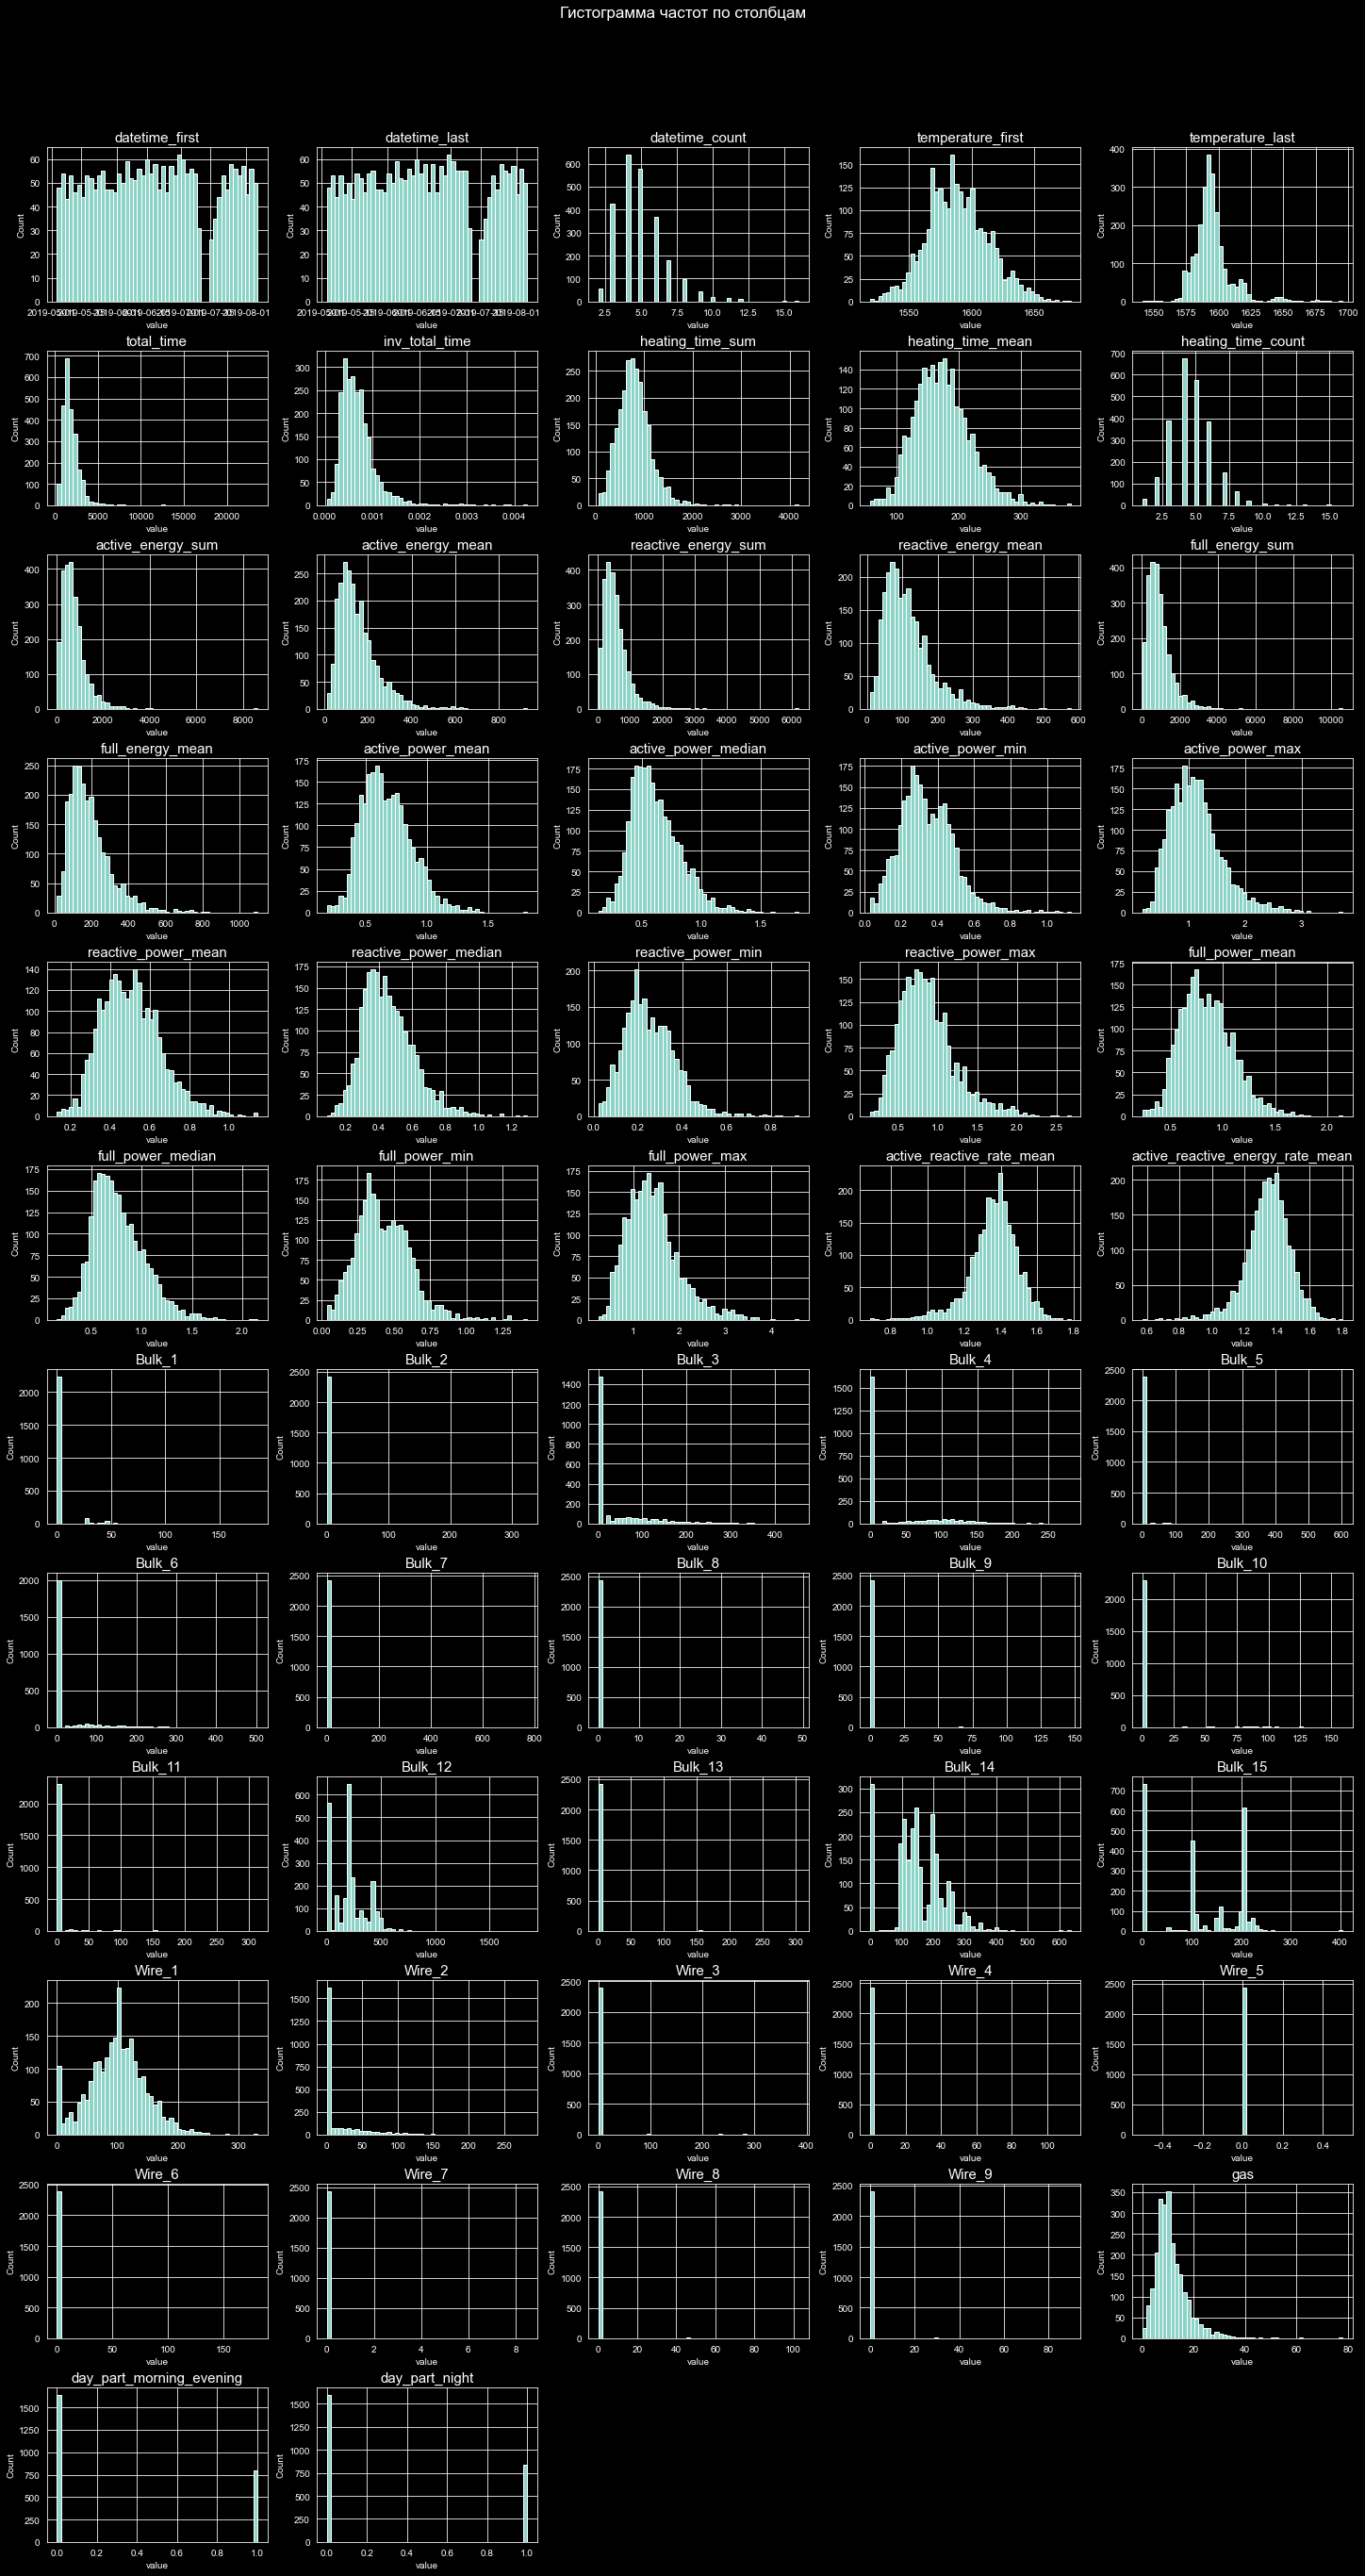

In [47]:
%%time

fig = plt.figure(constrained_layout=True, figsize=(20,12*3))

i = 0
for col in df_united.columns[1:-3]:
    i += 1
    ax = plt.subplot(12, 5, i)
    df_united[col].hist(bins=50, ax=ax)
    ax.set_title(col, fontsize=15);
    ax.set(xlabel="value", ylabel="Count")
#    plt.show()
    
fig.suptitle("Гистограмма частот по столбцам", fontsize=17, y=1.05);

In [48]:
# Посмотрим на партии по времени обработки.
df_united['total_time'].describe()

count    2,441.000
mean     1,864.043
std      1,305.451
min        234.000
25%      1,190.000
50%      1,599.000
75%      2,265.000
max     23,537.000
Name: total_time, dtype: float64

Из методики IQR следует что граница однозначных выбросов 
$${outliers}_{R} = Q_{75} + 3 \times IQR = 2265 + 3 \times (2265 - 1190) = 5490$$

Попробуем оставить ниже 10000

In [49]:
# Удаляем выбросы для total_time
# df_united = df_united.query('Bulk_5 < 0.2 and total_time< 10000')

In [50]:
print('До удаления: ', N)
print('После удаления', df_united.shape[0])
print(f"Удалили:{(N-df_united.shape[0])} шт ({(1-df_united.shape[0]/N):.2%})")

До удаления:  2475
После удаления 2441
Удалили:34 шт (1.37%)


Построим гистограммы после удаления аномальных партий

Wall time: 10.1 s


Text(0.5, 1.05, 'Гистограмма частот по столбцам')

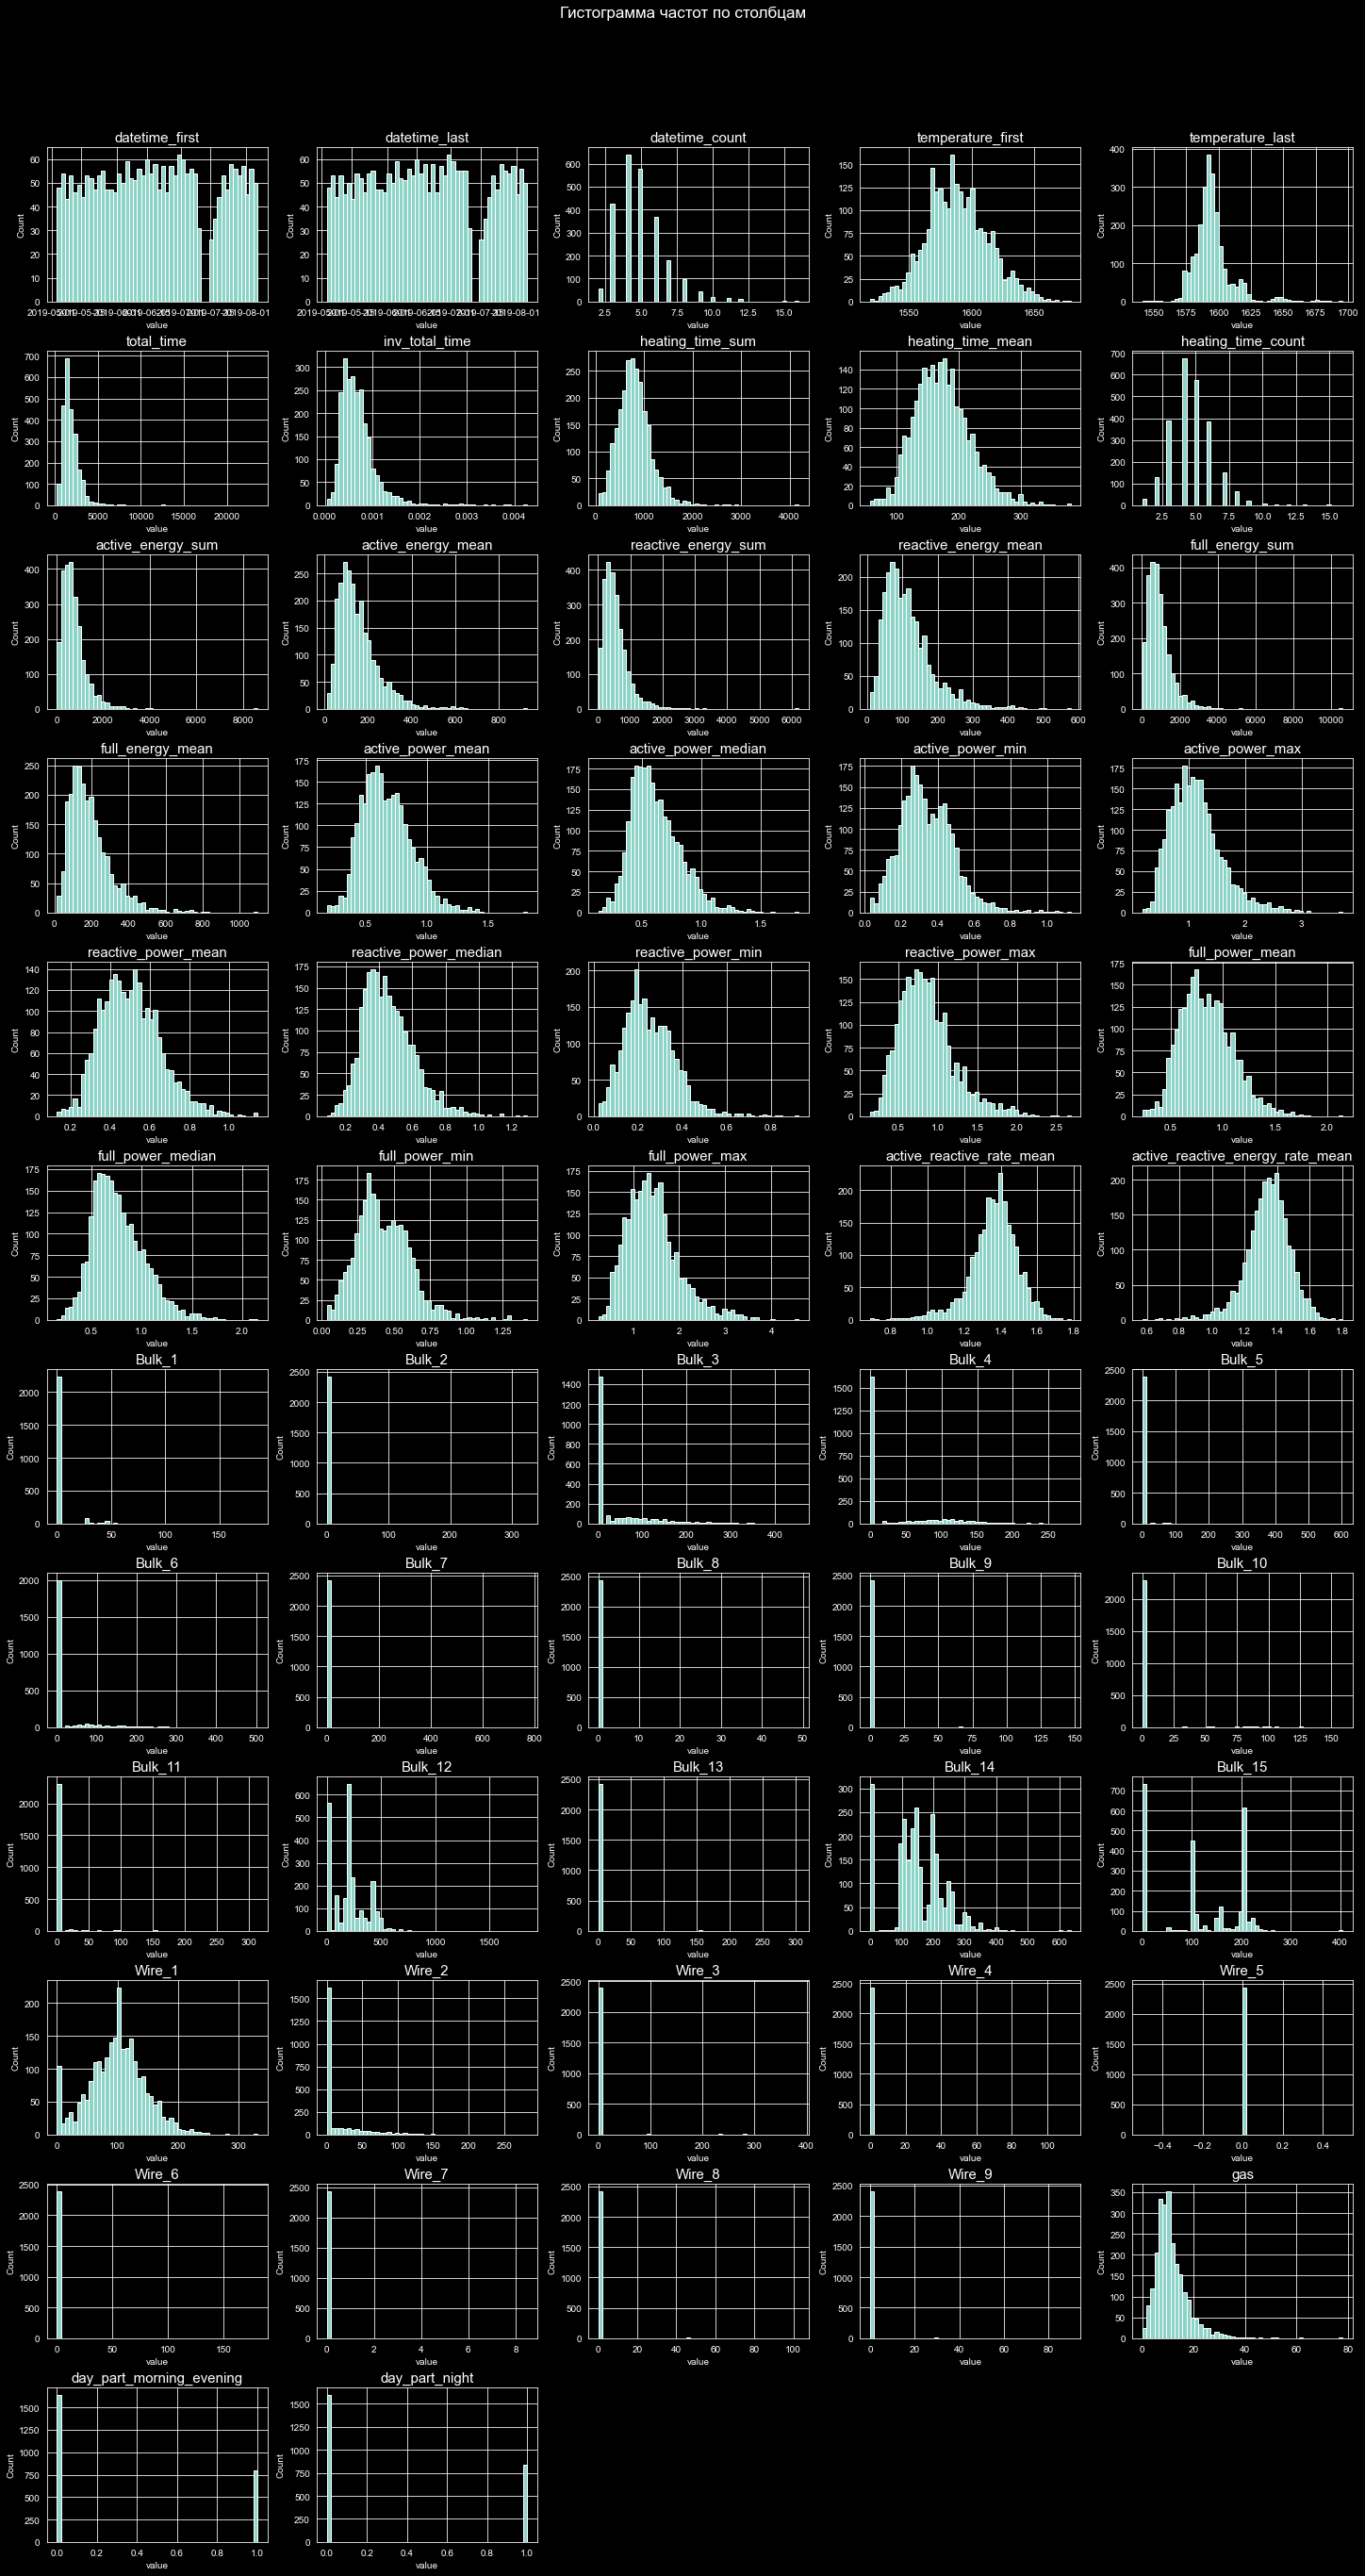

In [51]:
%%time

fig = plt.figure(constrained_layout=True, figsize=(20,12*3))

i = 0
for col in df_united.columns[1:-3]:
    i += 1
    ax = plt.subplot(12, 5, i)
    df_united[col].hist(bins=50, ax=ax)
    ax.set_title(col, fontsize=15);
    ax.set(xlabel="value", ylabel="Count")
#    plt.show()
    
fig.suptitle("Гистограмма частот по столбцам", fontsize=17, y=1.05);

In [52]:
list(df_united.columns)

['key',
 'datetime_first',
 'datetime_last',
 'datetime_count',
 'temperature_first',
 'temperature_last',
 'total_time',
 'inv_total_time',
 'heating_time_sum',
 'heating_time_mean',
 'heating_time_count',
 'active_energy_sum',
 'active_energy_mean',
 'reactive_energy_sum',
 'reactive_energy_mean',
 'full_energy_sum',
 'full_energy_mean',
 'active_power_mean',
 'active_power_median',
 'active_power_min',
 'active_power_max',
 'reactive_power_mean',
 'reactive_power_median',
 'reactive_power_min',
 'reactive_power_max',
 'full_power_mean',
 'full_power_median',
 'full_power_min',
 'full_power_max',
 'active_reactive_rate_mean',
 'active_reactive_energy_rate_mean',
 'Bulk_1',
 'Bulk_2',
 'Bulk_3',
 'Bulk_4',
 'Bulk_5',
 'Bulk_6',
 'Bulk_7',
 'Bulk_8',
 'Bulk_9',
 'Bulk_10',
 'Bulk_11',
 'Bulk_12',
 'Bulk_13',
 'Bulk_14',
 'Bulk_15',
 'Wire_1',
 'Wire_2',
 'Wire_3',
 'Wire_4',
 'Wire_5',
 'Wire_6',
 'Wire_7',
 'Wire_8',
 'Wire_9',
 'gas',
 'day_part_morning_evening',
 'day_part_night',
 

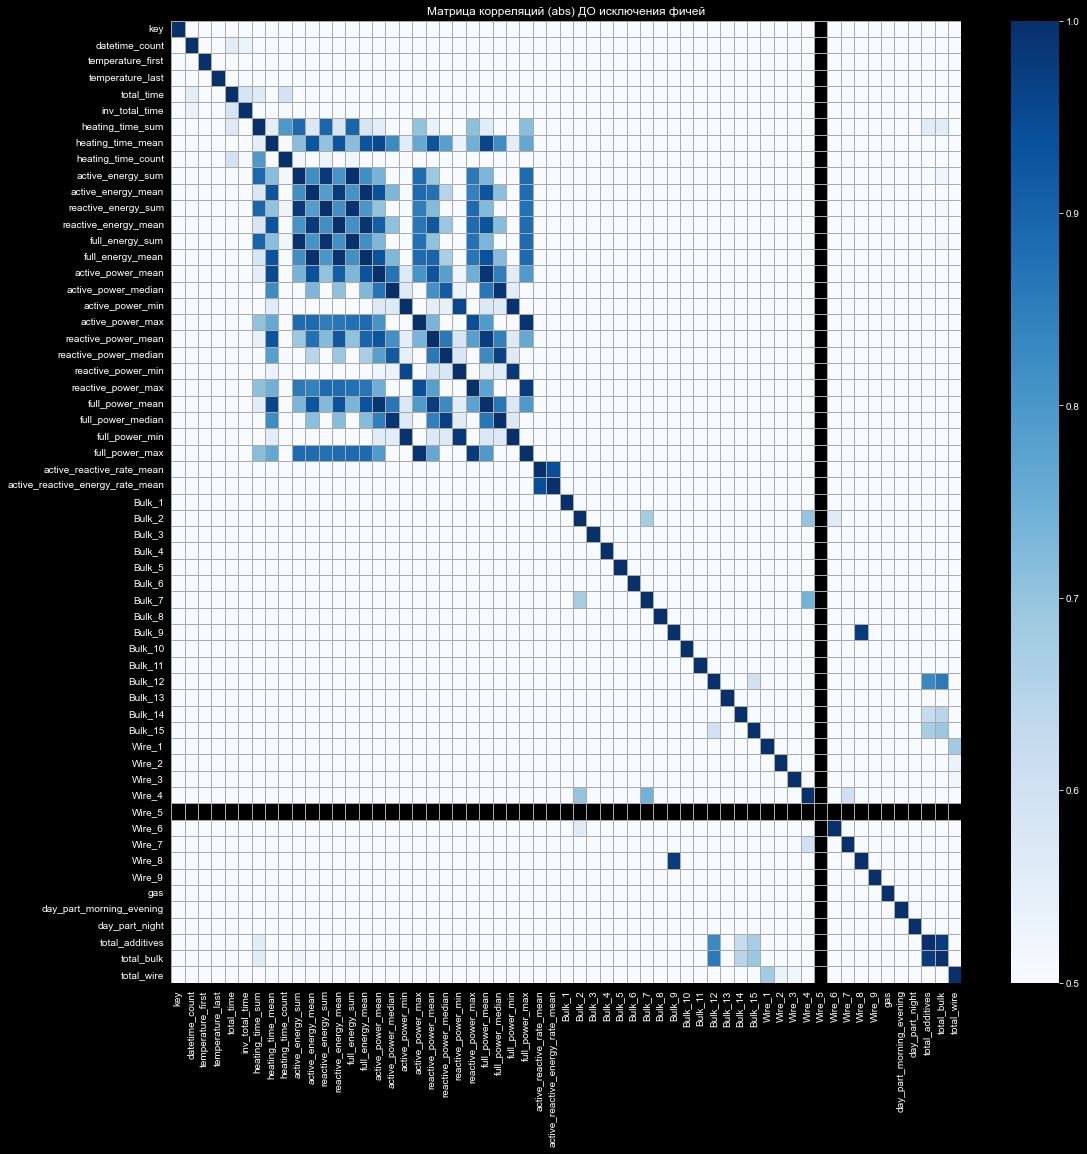

In [53]:
def highlight_cells2(val, color_if_true, color_if_false):
#     ======
#     Функция условного форматирования таблицы
#     ======
    color = color_if_true if val > 0.8 or val <-0.8 else color_if_false
    return 'background-color: {}'.format(color)

def show_corr_heatmap(df, list_feautures_to_delete, title='',absolute=True, display_corr=False):
#     ======
#     Функция построения матрицы корреляций с раскраской heatmap
#     ======
    corr = df_united.drop(columns = list_feautures_to_delete).corr()

    if display_corr:
        display(corr.style.applymap(highlight_cells2, color_if_true='#559955', color_if_false=None, subset=None))
    
    plt.figure(figsize=(corr.shape[1] * 0.3, (corr.shape[0] * 0.3)))
    
    if absolute:
        ax = sns.heatmap(np.abs(corr), annot=False, xticklabels = True, yticklabels = True, cmap="Blues", vmin=0.5, vmax=1, linewidths=.5, linecolor='#aaa')
    else:
        ax = sns.heatmap(corr, annot=False, xticklabels = True, yticklabels = True, cmap="RdBu", vmin=-1, vmax=1, linewidths=.5)
    ax.set_title(label=title)
    plt.show()

    
    
show_corr_heatmap(df_united, [], title='Матрица корреляций (abs) ДО исключения фичей')

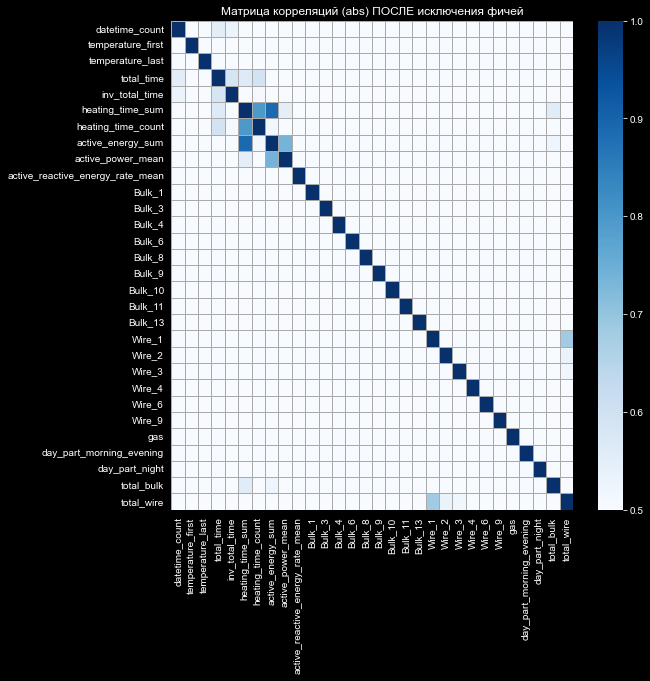

In [54]:

list_feautures_to_delete = [
    'key',
    'datetime_first',
    'datetime_last',
#     'datetime_count',
#     'temperature_first',
#     'temperature_last',
#     'total_time',
#     'inv_total_time',
#     'heating_time_sum',
    'heating_time_mean',
#     'heating_time_count',
#     'active_energy_sum',
    'active_energy_mean',
    'reactive_energy_sum',
    'reactive_energy_mean',
    'full_energy_sum',
    'full_energy_mean',
#     'active_power_mean',
    'active_power_median',
    'active_power_min',
    'active_power_max',
    'reactive_power_mean',
    'reactive_power_median',
    'reactive_power_min',
    'reactive_power_max',
    'full_power_mean',
    'full_power_median',
    'full_power_min',
    'full_power_max',
    'active_reactive_rate_mean',
#     'active_reactive_energy_rate_mean',
#     'Bulk_1',
    'Bulk_2',
#     'Bulk_3',
#     'Bulk_4',
    'Bulk_5',
#     'Bulk_6',
    'Bulk_7',
#     'Bulk_8',
#     'Bulk_9',
#     'Bulk_10',
#     'Bulk_11',
    'Bulk_12',
#     'Bulk_13',
    'Bulk_14',
    'Bulk_15',
#     'Wire_1',
#     'Wire_2',
#     'Wire_3',
#     'Wire_4',
    'Wire_5',
#     'Wire_6',
    'Wire_7',
    'Wire_8',
#     'Wire_9',
#     'gas',
#     'day_part_morning_evening',
#     'day_part_night',
    'total_additives',
#     'total_bulk',
#     'total_wire'
]

show_corr_heatmap(df_united, list_feautures_to_delete, title='Матрица корреляций (abs) ПОСЛЕ исключения фичей')

active_energy_sum и heating_time_sum коррелированы достаточно высоко (что ожидаемо), но пока оставим их в наборе, уберем после анализа значимости фичей

In [55]:
df_prepared = df_united.drop(columns = list_feautures_to_delete)

<b>Вывод:</b></br></br>
По итогу очистки от аномалий и выбросов были удалены 34 партий (1.37%)</br>
В результате анализа фичей и удаления сильно коррелированных фичей, остались 29 фичей из исходных 57

## подготовка train-test выборок

In [56]:
# Выделяем фичи и таргет
X = df_prepared.drop(axis=1, labels=['temperature_last'])
y = df_prepared['temperature_last']

# Делим dataset на Training set и Test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_STATE)

In [57]:
# смотрим на размеры train  и test
display(pd.DataFrame(
    data={
        'name': ['x_train', 'x_test', 'y_train', 'y_test'],
        'rows': [x_train.shape[0], x_test.shape[0], y_train.shape[0], y_test.shape[0]],
        'cols': [
            x_train.shape[1], 
            x_test.shape[1], 
            1 if type(y_train)==pd.core.series.Series  else y_train.shape[1], 
            1 if type(y_test)==pd.core.series.Series  else y_test.shape[1]
        ],
        'part': [x_train.shape[0] / X.shape[0], x_test.shape[0] / X.shape[0], y_train.shape[0] / y.shape[0], y_test.shape[0] / y.shape[0]],
    }
))

print('Проверка на равенство списка столбцов:', x_train.columns.equals(x_test.columns))
print('\n\nСписок столбцов')
list(x_train.columns)

,name,rows,cols,part
0,x_train,1952,29,0.800
1,x_test,489,29,0.200
2,y_train,1952,1,0.800
3,y_test,489,1,0.200


Проверка на равенство списка столбцов: True


Список столбцов


['datetime_count',
 'temperature_first',
 'total_time',
 'inv_total_time',
 'heating_time_sum',
 'heating_time_count',
 'active_energy_sum',
 'active_power_mean',
 'active_reactive_energy_rate_mean',
 'Bulk_1',
 'Bulk_3',
 'Bulk_4',
 'Bulk_6',
 'Bulk_8',
 'Bulk_9',
 'Bulk_10',
 'Bulk_11',
 'Bulk_13',
 'Wire_1',
 'Wire_2',
 'Wire_3',
 'Wire_4',
 'Wire_6',
 'Wire_9',
 'gas',
 'day_part_morning_evening',
 'day_part_night',
 'total_bulk',
 'total_wire']

# Исследовательский анализ данных

## построение моделей и подбор параметров

Сделаем свой pipeline, содержащий scaler + estimator

Для гибкости сделаем возможность параметрического задания transformers (можно несколько) и estimator (один всегда)

In [58]:
def custom_estimator(transformers, estimator):
    ppline_arr=[]

    
    if estimator == 'LinR':
        estm = LinearRegression(n_jobs=-1)
    elif estimator == 'GBR':
        estm = GradientBoostingRegressor(random_state=RANDOM_STATE)
    elif estimator == 'RFR':
        estm = RandomForestRegressor(random_state=RANDOM_STATE)
    elif estimator == 'HR':
        estm = HuberRegressor()
    elif estimator == 'PAR':
        estm = PassiveAggressiveRegressor(random_state=RANDOM_STATE)
    elif estimator == 'BAG':
        estm = BaggingRegressor(n_jobs=-1, random_state=RANDOM_STATE)
    elif estimator == 'HIST':
        estm = HistGradientBoostingRegressor(random_state=RANDOM_STATE)
    elif estimator == 'ADA':
        estm = AdaBoostRegressor(random_state=RANDOM_STATE)
    elif estimator == 'ARD':
        estm = ARDRegression()
    elif estimator == 'BR':
        estm = BayesianRidge()
    elif estimator == 'SGD':
        estm = SGDRegressor(random_state=RANDOM_STATE)
    elif estimator == 'ELASTIC':
        estm = ElasticNet(random_state=RANDOM_STATE)
    elif estimator == 'LGBM':
        estm = lgb.LGBMRegressor(objective="regression", random_state=RANDOM_STATE)
    else:
        # estimator == 'DUMMY':
        estm = DummyRegressor()
    
    
    for transformer in transformers:
        if transformer == 'RUS':
            trns = RandomUnderSampler(random_state=RANDOM_STATE)
        elif transformer == 'ENN':
            trns = EditedNearestNeighbours(n_jobs=-1)
        elif transformer == 'AllKNN':
            trns = AllKNN(n_jobs=-1)
        elif transformer == 'TL':
            trns = TomekLinks(n_jobs=-1)
        elif transformer == 'SMOTE':
            trns = SMOTE(random_state=RANDOM_STATE)
        elif transformer == 'ADASYN':
            trns = ADASYN(random_state=RANDOM_STATE)
        elif transformer == 'ROS':
            trns = RandomOverSampler(random_state=RANDOM_STATE)
        elif transformer == 'RS':
            trns = RobustScaler()
        elif transformer == 'SS':
            trns = StandardScaler()
        
        if transformer != 'NONE':
            ppline_arr.append((transformer,trns))
    
    ppline_arr.append(('estimator',estm))

    return Pipeline(ppline_arr)

Запускаем оптимизацию гиперпараметров через optuna.

Т.к. среди estimators есть такие, кто зависит от масштаба (например, LinRegression), то делаем StandardScaler, причем fit на x_train, а transform x_train и x_test

Кроссвалидация train на 4 фолдах с перемешиванием

В результате получаем лучшую модель, ее средний скор на train фолдах и оптимальные параметры

In [59]:
%%time

def objective(trial):
    """
    Кросс-валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train: матрица признаков
    :y_train: вектор меток объектов
    :return: средняя точность на кросс-валидации
    """ 

    
    
    pipeline = custom_estimator(transformers=transformers, estimator=estimator)
    params = {}
    
    # нулевую итерацию делаем с дефолтными параметрами
    if trial.number > 0:
        if estimator in ['RFR', 'GBR']:
            params = {
                 'estimator__criterion': trial.suggest_categorical('criterion', ['friedman_mse', 'mae'])
                 , 'estimator__n_estimators': 200
                 , 'estimator__max_depth': trial.suggest_int(name='max_depth', low=2, high=7, step=1, log=False)
                 , 'estimator__min_samples_leaf': trial.suggest_int(name='min_samples_leaf', low=1, high=30, step=1, log=False)
            }
            if estimator == 'GBR':
                params['estimator__loss'] = trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber'])
                params['estimator__learning_rate'] = trial.suggest_float(name='learning_rate', low=0.05, high=0.15, step=0.01, log=False)
                params['estimator__subsample'] = 0.7  #trial.suggest_float(name='subsample', low=0.3, high=0.99, step=0.01, log=False)
        elif estimator == 'LGBM':
            params = {
                'estimator__learning_rate': trial.suggest_float(name='learning_rate', low=0.001, high=0.1, step=0.001, log=False)
                , 'estimator__n_estimators': 1000
                , 'estimator__subsample' : 0.7
                , 'estimator__metrics':  trial.suggest_categorical('metrics', ['mae', 'huber', 'mse'])
                , 'estimator__num_leaves': trial.suggest_int(name='num_leaves', low=5, high=100, step=1, log=False) 
                , 'estimator__random_state': RANDOM_STATE
            }
            
        elif estimator == 'DUMMY':
            params = {
                 'estimator__strategy': trial.suggest_categorical('strategy', ['mean', 'median'])
            }
        elif estimator == 'BAG':
            params = {
                 'estimator__n_estimators': trial.suggest_int(name='n_estimators', low=10, high=50, step=1, log=True)
                , 'estimator__max_samples': trial.suggest_int(name='max_samples', low=1, high=5, step=1, log=False)
                , 'estimator__max_features': trial.suggest_int(name='max_features', low=1, high=7, step=1, log=False)
            }
        elif estimator == 'HIST':
            params = {
                 'estimator__loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'poisson'])
                , 'estimator__learning_rate': trial.suggest_float(name='learning_rate', low=0.1, high=0.3, step=0.01, log=False)
                , 'estimator__max_leaf_nodes': trial.suggest_int(name='max_leaf_nodes', low=31, high=101, step=1, log=False)
#                 , 'estimator__max_depth': trial.suggest_int(name='max_depth', low=2, high=100, step=1, log=True)
            }
        elif estimator == 'ADA':
            params = {
                 'estimator__loss': trial.suggest_categorical('loss', ['linear', 'square', 'exponential'])
                , 'estimator__learning_rate': trial.suggest_float(name='learning_rate', low=0.1, high=0.3, step=0.01, log=False)
                , 'estimator__n_estimators': trial.suggest_int(name='n_estimators', low=10, high=50, step=1, log=True)
#                 , 'estimator__max_depth': trial.suggest_int(name='max_depth', low=2, high=100, step=1, log=True)
            }
        elif estimator == 'ELASTIC':
            
            params = {
                 'estimator__l1_ratio': trial.suggest_float(name='l1_ratio', low=0.001, high=0.999, step=0.001, log=False)
            }
                 
    
    # задаём модели требуемые параметры    
    pipeline.set_params(**params)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    kf = KFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=pipeline, X=X, y=y, 
                            scoring='neg_mean_absolute_error', cv=kf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return   score.mean()
# ======<<<<======<<<<======<<<<======<<<<======<<<<======<<<<======<<<<
if True: 
# ======<<<<======<<<<======<<<<======<<<<======<<<<======<<<<======<<<<

    X = x_train
    y = y_train

    best_score_ = -10000
    log_history = {}
#         ['DUMMY', 'LinR', 'PAR', 'BAG', 'HIST', 'ADA', 'ARD', 'BR', 'SGD', 'ELASTIC']
    for est in ['DUMMY', 'LinR', 'GBR', 'LGBM']:
        print('\n--------------', est,'--------------------')
        t1 = time.time()
        
        if est in ['RFR', 'GBR','BAG', 'HIST', 'ADA', 'ELASTIC', 'LGBM']:
            n_attempts = 50
        elif est in ['DUMMY']:
            n_attempts = 10
        else:
            n_attempts = 1

        transformers=['SS']
        estimator=est
        
        sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE)
        study = optuna.create_study(sampler=sampler, direction="maximize")
        study.optimize(objective, n_trials=n_attempts, timeout=60*60, n_jobs=1, show_progress_bar=True)
        
        print ('estimator ', est, 'best score is', 'score=', -study.best_trial.values[0] , 'params=',  study.best_trial.params, '\n')
        
        if best_score_ <= study.best_trial.values[0]:
            best_params_ = study.best_trial.params
            best_estimator_ = estimator
            best_score_ = study.best_trial.values[0]
        log_history.update({estimator:{
            'score': study.best_trial.values[0],
            'params': study.best_trial.params,
            'time': time.time() - t1
        }})
    print(log_history)
    print ('BEST is', best_estimator_, 'score=', best_score_ , 'params=',  best_params_)                        


[I 2022-09-03 17:08:23,662] A new study created in memory with name: no-name-0fa7e346-ba01-4c19-a0c9-7b655c8b6627



-------------- DUMMY --------------------


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-09-03 17:08:25,421] Trial 0 finished with value: -9.575088321911672 and parameters: {}. Best is trial 0 with value: -9.575088321911672.
[I 2022-09-03 17:08:25,455] Trial 1 finished with value: -9.354508196721312 and parameters: {'strategy': 'median'}. Best is trial 1 with value: -9.354508196721312.
[I 2022-09-03 17:08:25,481] Trial 2 finished with value: -9.354508196721312 and parameters: {'strategy': 'median'}. Best is trial 1 with value: -9.354508196721312.
[I 2022-09-03 17:08:25,508] Trial 3 finished with value: -9.354508196721312 and parameters: {'strategy': 'median'}. Best is trial 1 with value: -9.354508196721312.
[I 2022-09-03 17:08:25,534] Trial 4 finished with value: -9.354508196721312 and parameters: {'strategy': 'median'}. Best is trial 1 with value: -9.354508196721312.
[I 2022-09-03 17:08:25,562] Trial 5 finished with value: -9.575088321911672 and parameters: {'strategy': 'mean'}. Best is trial 1 with value: -9.354508196721312.
[I 2022-09-03 17:08:25,587] Trial 6 fi

[I 2022-09-03 17:08:25,668] A new study created in memory with name: no-name-d1b07e8b-9630-4f0f-b57b-582291999567



[I 2022-09-03 17:08:25,637] Trial 8 finished with value: -9.575088321911672 and parameters: {'strategy': 'mean'}. Best is trial 1 with value: -9.354508196721312.
[I 2022-09-03 17:08:25,663] Trial 9 finished with value: -9.575088321911672 and parameters: {'strategy': 'mean'}. Best is trial 1 with value: -9.354508196721312.
estimator  DUMMY best score is score= 9.354508196721312 params= {'strategy': 'median'} 


-------------- LinR --------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2022-09-03 17:08:25,750] A new study created in memory with name: no-name-b422c3a8-9824-4c08-8b79-fee2982f6b60


[I 2022-09-03 17:08:25,745] Trial 0 finished with value: -6.402184854301392 and parameters: {}. Best is trial 0 with value: -6.402184854301392.
estimator  LinR best score is score= 6.402184854301392 params= {} 


-------------- GBR --------------------


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2022-09-03 17:08:26,332] Trial 0 finished with value: -5.982001050244543 and parameters: {}. Best is trial 0 with value: -5.982001050244543.
[I 2022-09-03 17:08:43,123] Trial 1 finished with value: -6.122683890372043 and parameters: {'criterion': 'mae', 'max_depth': 3, 'min_samples_leaf': 12, 'loss': 'absolute_error', 'learning_rate': 0.15}. Best is trial 0 with value: -5.982001050244543.
[I 2022-09-03 17:08:45,479] Trial 2 finished with value: -5.79750109413311 and parameters: {'criterion': 'friedman_mse', 'max_depth': 5, 'min_samples_leaf': 13, 'loss': 'huber', 'learning_rate': 0.07}. Best is trial 2 with value: -5.79750109413311.
[I 2022-09-03 17:08:46,239] Trial 3 finished with value: -6.037511114022649 and parameters: {'criterion': 'friedman_mse', 'max_depth': 3, 'min_samples_leaf': 27, 'loss': 'squared_error', 'learning_rate': 0.060000000000000005}. Best is trial 2 with value: -5.79750109413311.
[I 2022-09-03 17:08:49,576] Trial 4 finished with value: -6.05633841342659 and par

[I 2022-09-03 17:14:21,220] A new study created in memory with name: no-name-a9e0ebf1-04a6-4a2d-a753-28a12eb5a655


[I 2022-09-03 17:14:21,215] Trial 49 finished with value: -6.001353232376637 and parameters: {'criterion': 'friedman_mse', 'max_depth': 7, 'min_samples_leaf': 30, 'loss': 'absolute_error', 'learning_rate': 0.05}. Best is trial 29 with value: -5.782768675138314.
estimator  GBR best score is score= 5.782768675138314 params= {'criterion': 'friedman_mse', 'max_depth': 5, 'min_samples_leaf': 11, 'loss': 'huber', 'learning_rate': 0.07} 


-------------- LGBM --------------------


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2022-09-03 17:14:22,674] Trial 0 finished with value: -6.076373067306607 and parameters: {}. Best is trial 0 with value: -6.076373067306607.
[I 2022-09-03 17:14:26,199] Trial 1 finished with value: -6.22762990089831 and parameters: {'learning_rate': 0.061, 'metrics': 'mae', 'num_leaves': 51}. Best is trial 0 with value: -6.076373067306607.
[I 2022-09-03 17:14:27,709] Trial 2 finished with value: -6.139012000788388 and parameters: {'learning_rate': 0.07, 'metrics': 'mse', 'num_leaves': 21}. Best is trial 0 with value: -6.076373067306607.
[I 2022-09-03 17:14:31,644] Trial 3 finished with value: -6.232342755686194 and parameters: {'learning_rate': 0.061, 'metrics': 'huber', 'num_leaves': 77}. Best is trial 0 with value: -6.076373067306607.
[I 2022-09-03 17:14:35,220] Trial 4 finished with value: -6.186094419226654 and parameters: {'learning_rate': 0.021, 'metrics': 'mae', 'num_leaves': 88}. Best is trial 0 with value: -6.076373067306607.
[I 2022-09-03 17:14:39,013] Trial 5 finished wit

## Выбор важных фич

Проведем отбор значимых фичей с помощью BorutaShap
</br>
Делать будем с кросс-валидацией, выявляя на каждом фолде значимые фичи и потом, сформируем список значимых фичей по принципу "значимые те, кто был значим хотя бы на одном фолде"

https://medium.com/analytics-vidhya/is-this-the-best-feature-selection-algorithm-borutashap-8bc238aa1677
https://www.kaggle.com/code/lucamassaron/tutorial-feature-selection-with-boruta-shap/notebook

FOLD 1/4


  0%|          | 0/50 [00:00<?, ?it/s]

11 attributes confirmed important: ['active_power_mean', 'total_time', 'Wire_1', 'Wire_2', 'active_energy_sum', 'inv_total_time', 'active_reactive_energy_rate_mean', 'Bulk_6', 'heating_time_sum', 'total_wire', 'temperature_first']
17 attributes confirmed unimportant: ['Bulk_3', 'day_part_morning_evening', 'datetime_count', 'Bulk_9', 'Bulk_13', 'Wire_4', 'Wire_6', 'day_part_night', 'Bulk_1', 'Bulk_8', 'Bulk_11', 'Bulk_10', 'Wire_9', 'heating_time_count', 'Wire_3', 'gas', 'total_bulk']
1 tentative attributes remains: ['Bulk_4']


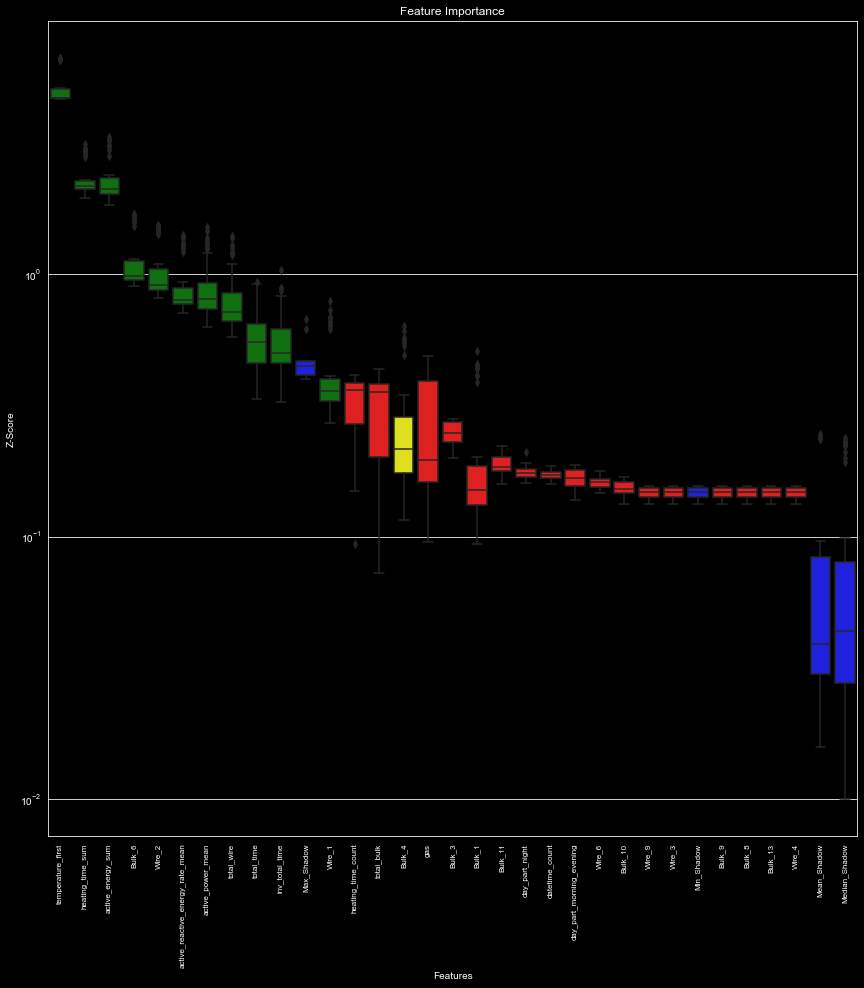

Selected features at fold 1 are: ['Bulk_6', 'Wire_1', 'Wire_2', 'active_energy_sum', 'active_power_mean', 'active_reactive_energy_rate_mean', 'heating_time_sum', 'inv_total_time', 'temperature_first', 'total_time', 'total_wire']
FOLD 2/4


  0%|          | 0/50 [00:00<?, ?it/s]

12 attributes confirmed important: ['active_power_mean', 'total_time', 'Bulk_1', 'Wire_1', 'Wire_2', 'active_energy_sum', 'inv_total_time', 'active_reactive_energy_rate_mean', 'Bulk_6', 'heating_time_sum', 'total_wire', 'temperature_first']
13 attributes confirmed unimportant: ['Bulk_3', 'day_part_morning_evening', 'datetime_count', 'Bulk_9', 'Bulk_13', 'Wire_4', 'Wire_6', 'day_part_night', 'Bulk_8', 'Bulk_11', 'Bulk_10', 'Wire_9', 'Wire_3']
4 tentative attributes remains: ['Bulk_4', 'gas', 'total_bulk', 'heating_time_count']


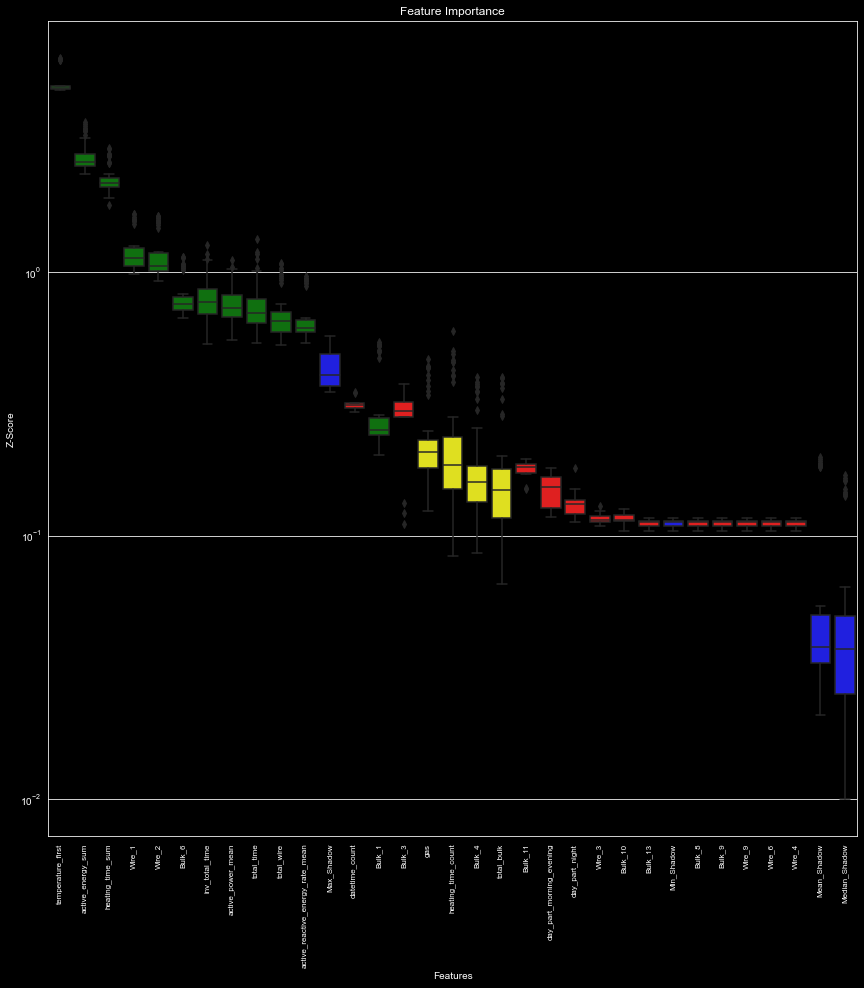

Selected features at fold 2 are: ['Bulk_1', 'Bulk_6', 'Wire_1', 'Wire_2', 'active_energy_sum', 'active_power_mean', 'active_reactive_energy_rate_mean', 'heating_time_sum', 'inv_total_time', 'temperature_first', 'total_time', 'total_wire']
FOLD 3/4


  0%|          | 0/50 [00:00<?, ?it/s]

12 attributes confirmed important: ['active_power_mean', 'total_time', 'gas', 'Wire_1', 'Wire_2', 'active_energy_sum', 'inv_total_time', 'active_reactive_energy_rate_mean', 'Bulk_6', 'heating_time_sum', 'total_wire', 'temperature_first']
16 attributes confirmed unimportant: ['Bulk_3', 'day_part_morning_evening', 'datetime_count', 'Bulk_9', 'Bulk_13', 'Wire_4', 'Wire_6', 'day_part_night', 'Bulk_4', 'Bulk_8', 'Bulk_11', 'Bulk_10', 'Wire_9', 'heating_time_count', 'Wire_3', 'total_bulk']
1 tentative attributes remains: ['Bulk_1']


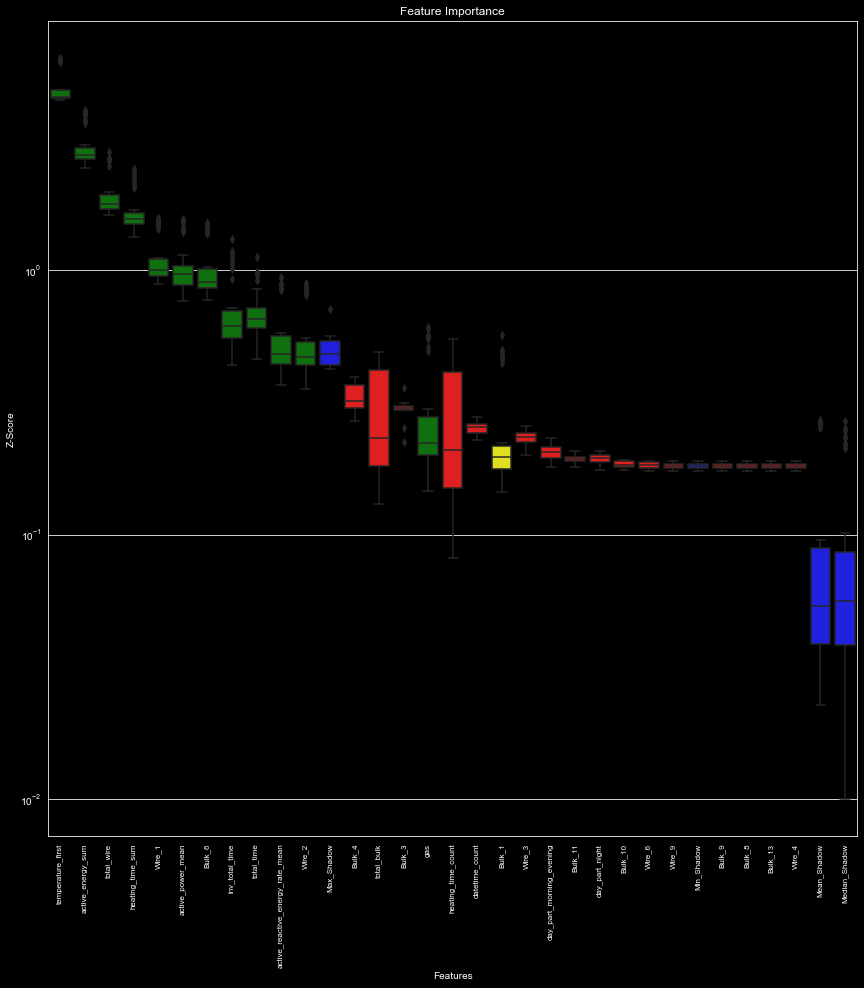

Selected features at fold 3 are: ['Bulk_6', 'Wire_1', 'Wire_2', 'active_energy_sum', 'active_power_mean', 'active_reactive_energy_rate_mean', 'gas', 'heating_time_sum', 'inv_total_time', 'temperature_first', 'total_time', 'total_wire']
FOLD 4/4


  0%|          | 0/50 [00:00<?, ?it/s]

15 attributes confirmed important: ['active_power_mean', 'total_time', 'gas', 'Bulk_1', 'Wire_1', 'heating_time_count', 'Wire_2', 'active_energy_sum', 'inv_total_time', 'active_reactive_energy_rate_mean', 'Bulk_6', 'heating_time_sum', 'total_bulk', 'total_wire', 'temperature_first']
13 attributes confirmed unimportant: ['day_part_morning_evening', 'datetime_count', 'Bulk_9', 'Bulk_13', 'Wire_4', 'Wire_6', 'day_part_night', 'Bulk_4', 'Bulk_8', 'Bulk_11', 'Bulk_10', 'Wire_9', 'Wire_3']
1 tentative attributes remains: ['Bulk_3']


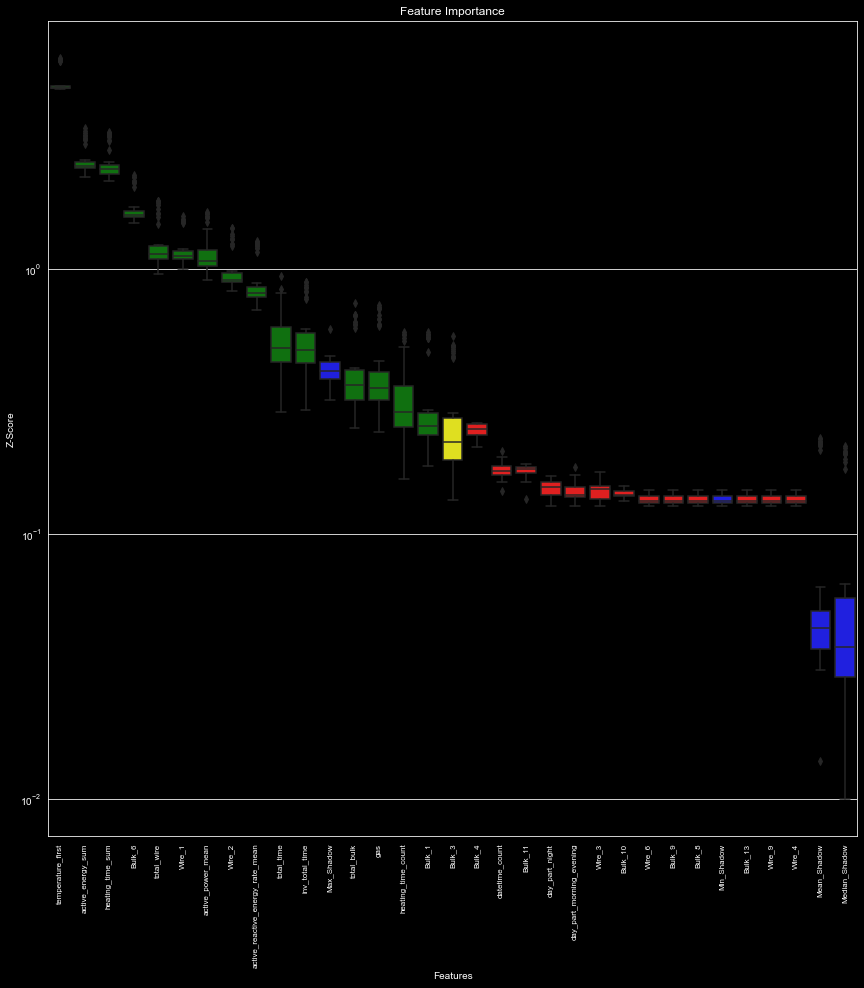

Selected features at fold 4 are: ['Bulk_1', 'Bulk_6', 'Wire_1', 'Wire_2', 'active_energy_sum', 'active_power_mean', 'active_reactive_energy_rate_mean', 'gas', 'heating_time_count', 'heating_time_sum', 'inv_total_time', 'temperature_first', 'total_bulk', 'total_time', 'total_wire']


In [60]:
folds = 4
kf = KFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)

estimator = best_estimator_
est = estimator
params = best_params_

# Feature Scaling
sc = StandardScaler()
x_train_scaled = pd.DataFrame(data=sc.fit_transform(x_train), columns=x_train.columns, index=x_train.index)
x_test_scaled = pd.DataFrame(data=sc.transform(x_test), columns=x_test.columns, index=x_test.index)

# params = params_best[est]
if est == 'GBR':
    model = GradientBoostingRegressor(**params, random_state=RANDOM_STATE)
elif est == 'LGBM':
    model = lgb.LGBMRegressor(objective="regression", random_state=RANDOM_STATE, **params)


selected_columns = list()
    
for k, (train_idx, val_idx) in enumerate(kf.split(x_train_scaled, y_train)):
    
    print(f"FOLD {k+1}/{folds}")
#     print(train_idx)
#     print(type(train_idx))
#     print(y_train.index)
#     print(set(train_idx).difference(set(y_train.index)))
#     print(x_train_scaled.iloc[train_idx])
    if est == 'GBR':
        model = GradientBoostingRegressor(**params, random_state=RANDOM_STATE)
    elif est == 'LGBM':
        model = lgb.LGBMRegressor(objective="regression", random_state=RANDOM_STATE, **params)

    Feature_Selector = BorutaShap(model=model,
                                  importance_measure='shap', 
                                  classification=False)

#     print(x_train_scaled.iloc[train_idx,:])
#     print(y_train.iloc[train_idx])
    Feature_Selector.fit(X=x_train_scaled.iloc[train_idx], y=y_train.iloc[train_idx], n_trials=50, random_state=0)
    
    Feature_Selector.plot(which_features='all', figsize=(x_train_scaled.shape[1]*0.5,15))
    
    selected_columns.append(sorted(Feature_Selector.Subset().columns))
    
    print(f"Selected features at fold {k+1} are: {selected_columns[-1]}")

In [61]:
final_selection = sorted({item for selection in selected_columns for item in selection})
print(final_selection)

['Bulk_1', 'Bulk_6', 'Wire_1', 'Wire_2', 'active_energy_sum', 'active_power_mean', 'active_reactive_energy_rate_mean', 'gas', 'heating_time_count', 'heating_time_sum', 'inv_total_time', 'temperature_first', 'total_bulk', 'total_time', 'total_wire']


<b>ВЫВОД:</b></br></br>
В результате отбора важных фич мы сократили список с 29 до 15шт</br>
Точность модели не ухудшилась при этом.

## проверка на test

Лучшую модель выбрали. Смотрим как себя поведет лучшая модель на test выборке

In [62]:
%%time

# estimator = best_estimator_
# est = estimator
# params = best_params_

if best_estimator_ == 'GBR':
    params['n_estimators'] = 200

elif best_estimator_ == 'LGBM':
    params['n_estimators'] = 1000


t1 = time.time()

pipeline = custom_estimator(transformers=['SS'], estimator=estimator)

y_pred = {}
y_act = {}

# params = params_best[estimator]
params_prefix = {'estimator__'+name: v for name, v in params.items()}
pipeline.set_params(**params_prefix)

y_act = y_test

model_fit = pipeline.fit(x_train[final_selection], y_train)
y_pred = pipeline.predict(x_test[final_selection])

print('estimator', estimator, 'res', mean_absolute_error(y_act, y_pred), 'time', time.time() - t1)


estimator GBR res 5.650085570028289 time 3.0599052906036377
Wall time: 3.06 s


<b>ВЫВОД:</b></br></br>
Все хорошо, метрика хорошая, на тесте метрика примерно равна метрике на train, что говорит, что мы не переобучили модель

## Значимость фич на test

Посмотрим значимость фичей инструментом SHAP

2022-09-03 17:22:40


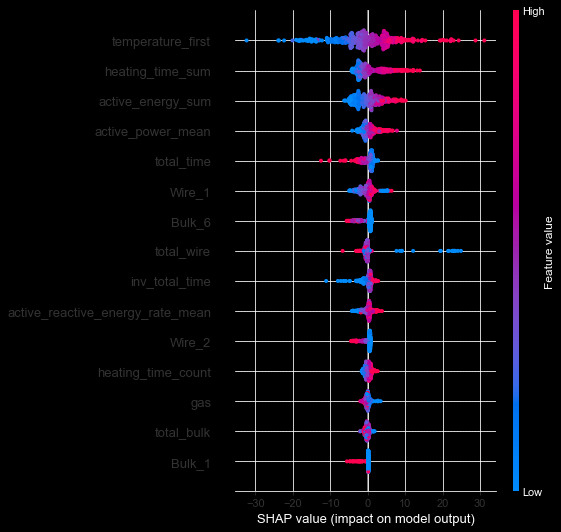

estimator GBR res 5.650085570028289 time 4.010810613632202
Wall time: 4.01 s


In [63]:
%%time
print(dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

# Feature Scaling
# sc = StandardScaler()
# x_train_boruta_shap_ = sc.fit_transform(X_train_boruta_shap)
# x_test_boruta_shap_= sc.transform(X_test_boruta_shap)
x_train_boruta_shap = x_train_scaled[final_selection]
x_test_boruta_shap = x_test_scaled[final_selection]


t1 = time.time()


y_pred = {}
y_act = {}
#     N = 20000



if est == 'GBR':
    model = GradientBoostingRegressor(**params, random_state=RANDOM_STATE)
elif est == 'LGBM':
    model = lgb.LGBMRegressor(objective="regression", random_state=RANDOM_STATE, **params)



y_act = y_test

model_fit = model.fit(x_train_boruta_shap, y_train)
y_pred = model_fit.predict(x_test_boruta_shap)

shap_test = shap.TreeExplainer(model_fit).shap_values(x_test_boruta_shap)
shap.summary_plot(shap_test, x_test_boruta_shap, max_display=25, auto_size_plot=True)

print('estimator', est, 'res', mean_absolute_error(y_act, y_pred), 'time', time.time() - t1)

<b>ВЫВОД:</b></br></br>
Видно, что 
- все фичи имеют полярную раскраску. что говорит о их систематическом влиянии на результаты модели
- примерно треть фичей не сильно повлияли на результат модели, при необъодимости их можно убрать из модели для ее упрощения

## Анализ отклонений (выбросов)

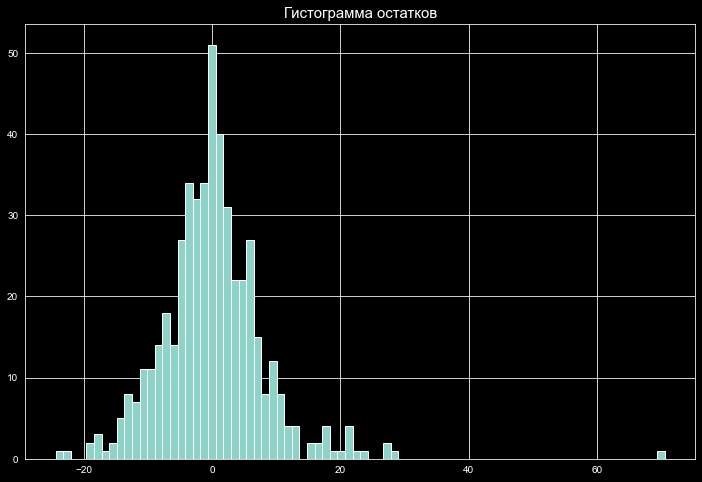

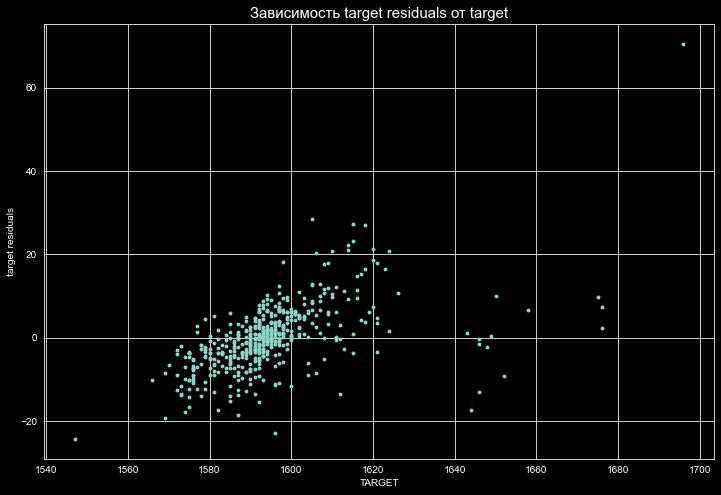

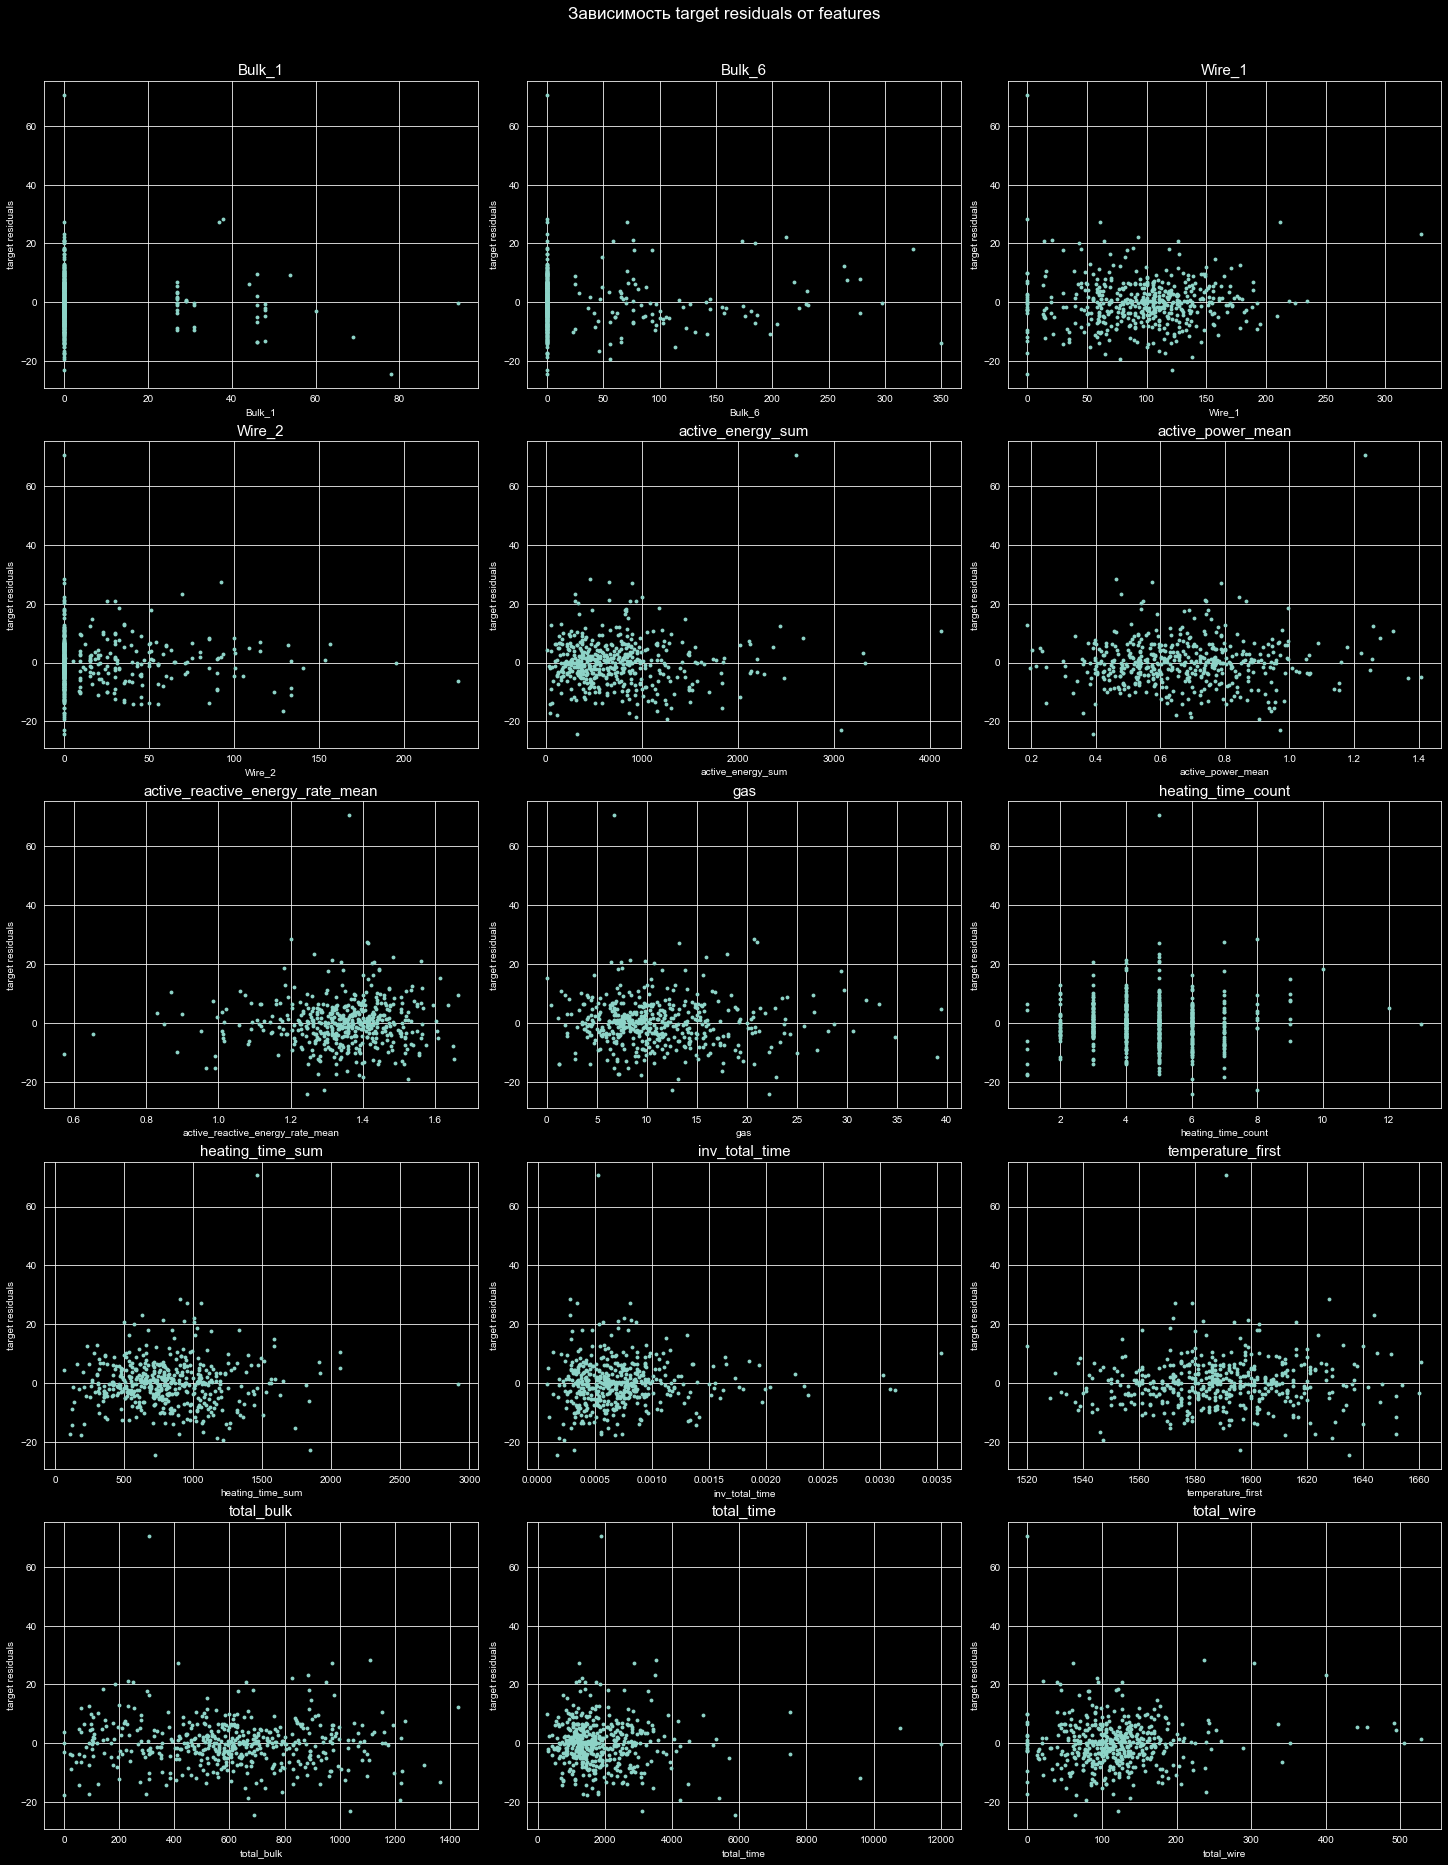

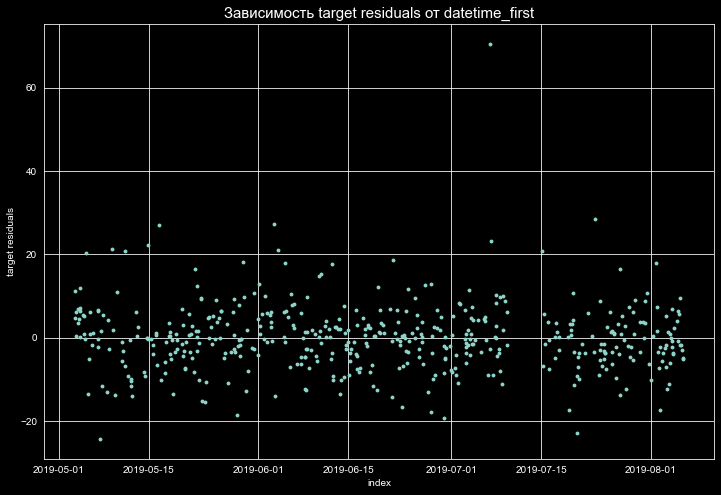

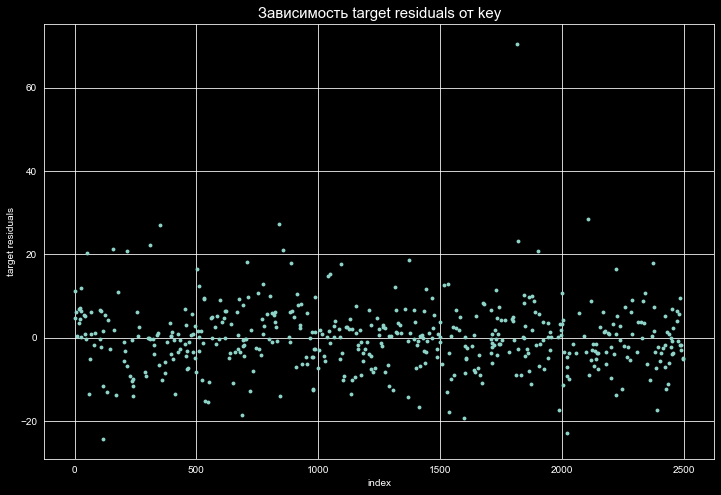

2022-09-03 17:22:49


In [64]:
x_test_important_orig = x_test[final_selection]
N = len(x_test_important_orig.columns)
rows = np.ceil(N/3.0)
y_abs_err = np.abs(y_act - y_pred)
y_residuals = (y_act - y_pred)

ax = y_residuals.hist(bins=80)
ax.set_title('Гистограмма остатков', fontsize=15);
plt.show()

ax = sns.scatterplot(y=y_residuals, x=y_test, linewidth=0, alpha=1, s=15)
ax.set_title('Зависимость target residuals от target', fontsize=15);
ax.set(xlabel='TARGET', ylabel="target residuals")
plt.show()

fig = plt.figure(constrained_layout=True, figsize=(20,rows*5))

i = 0

for col in x_test_important_orig.columns:
    i += 1
    ax = plt.subplot(rows, 3, i)
    sns.scatterplot(
        y=y_residuals, 
        x=x_test_important_orig[col], 
        ax=ax, linewidth=0, alpha=1, s=15
    )
    ax.set_title(col, fontsize=15);

    ax.set(xlabel=col, ylabel="target residuals")

    
fig.suptitle("Зависимость target residuals от features", fontsize=17, y=1.03);
plt.show()

ax = sns.scatterplot(y=y_residuals, x=df_united.loc[y_test.index, 'datetime_first'], linewidth=0, alpha=1, s=15)
ax.set_title('Зависимость target residuals от datetime_first', fontsize=15);
ax.set(xlabel='index', ylabel="target residuals")
plt.show()

ax = sns.scatterplot(y=y_residuals, x=df_united.loc[y_test.index, 'key'], linewidth=0, alpha=1, s=15)
ax.set_title('Зависимость target residuals от key', fontsize=15);
ax.set(xlabel='index', ylabel="target residuals")
plt.show()

print(dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [65]:
# Посмотрим на выбросы
lst_idx_bigres = list(y_residuals[y_residuals>60].index)
df_prepared.loc[lst_idx_bigres,:]

,datetime_count,temperature_first,temperature_last,total_time,inv_total_time,heating_time_sum,heating_time_count,active_energy_sum,active_power_mean,active_reactive_energy_rate_mean,Bulk_1,Bulk_3,Bulk_4,Bulk_6,Bulk_8,Bulk_9,Bulk_10,Bulk_11,Bulk_13,Wire_1,Wire_2,Wire_3,Wire_4,Wire_6,Wire_9,gas,day_part_morning_evening,day_part_night,total_bulk,total_wire
1800,8,"1,591.000","1,696.000",1880,0.001,"1,459.000",5.000,"2,601.434",1.235,1.362,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,6.747,1,0,308.000,0.000


<b>ВЫВОД:</b></br></br>
1. Остатки нормальны. Модель плохо предсказала одно значение, но оно одно и не может свидетельствовать о отсутствии нормальности в остатках. Этот выброс не связан в каким-то параметром (фичей)
2. Остатки независимы от предсказанных значений (левый верхний график scatter) и не зависят от фич (остальные графики scatter)
3. Остатки не зависят от времени и номера партии (key)

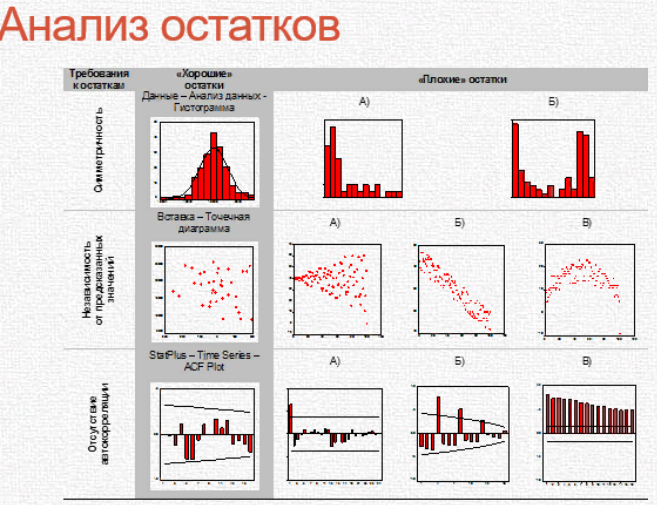

# Итоговые выводы

В результате проекта был проведен исследовательский анализ данных:
- Изучены и подготовлены для анализа предоставленные данные
- Проанализирован порядок событий в производственном процессе, выявлены ошибки в регистрации времени в таблицах bulk_time и wire_time
- Из рассмотрения были исключены партии (1.4% или 36 шт), которые 
 - не имеют последнего замера температуры, 
 - первый замер температуры соответствует последнему, 
 - замеры температуры отсутствуют
 - начальная температура менее 1400°С (температура плавления стали)
 - ~~время работы с партией более 10000 сек~~
 - у партии всекомпоненты добавок (и wire и bulk) равны нулю
 - у партии расход газа равен нулю
- Подготовлены дополнительные поля-признаки
    1.	Начальная температура
    2.	Число замеров температуры
    3.	Время обработки партии
    4.	Обратное время обработки партии
    5.	Время нагревов суммарное
    6.	Время нагревов среднее
    7.	Число нагревов
    8.	Активная энергия используемая для нагрева стали в ковше
    9.	Средняя активная энергия используемая для нагрева стали в ковше
    10.	Реактивная энергия используемая для нагрева стали в ковше
    11.	Средняя реактивная энергия используемая для нагрева стали в ковше
    12.	Полная энергия используемая для нагрева стали в ковше
    13.	Средняя полная энергия используемая для нагрева стали в ковше
    14.	Максимальная мощность активной энергии
    15.	Максимальная мощность реактивной энергии
    16.	Максимальная мощность полной энергии
    17.	Минимальная мощность активной энергии
    18.	Минимальная мощность реактивной энергии
    19.	Минимальная мощность полной энергии
    20.	Средняя мощность активной энергии
    21.	Средняя мощность реактивной энергии
    22.	Средняя мощность полной энергии
    23.	Медианная мощность активной энергии
    24.	Медиана мощность реактивной энергии
    25.	Медианная мощность полной энергии
    26.	Количество использованного Газа
    27.	Соотношение активной и реактивной мощностей средняя
    28.	Соотношение использованных активной и реактивной энергии
    29.	Компоненты bulk_1..bulk_15
    43.	Компоненты wire_1… wire_9
    51.	Сумма bulk
    52.	Сумма wire
    53.	Время суток (ночь) для первого замера температуры
    54.	Время суток (утро/вечер) для первого замера температуры

    - Проведена признаки на мультиколлинеарность и исключены лишние признаки (оставлены 29 из 57)
- Модель, которая предскажет температуру расплава стали:
    - Сформированы обучающая train и тестовая test выборки (80/20)
    - Подготовлена процедура с помощью OPTUNA подбора лучшей по метрике MAE модели и для нее лучших гиперпараметров на нескольких моделях
     - DummyRegressor
     - LinearRegression
     - GradientBoostingRegressor
     - LightGBM
    - Проведено масштабирование признаков
    - Выбрана лучшая модель (GradientBoostingRegressor с метрикой MAE = 5.783) и оптимальные параметры OPTUNA c CrossValidation на 4 фолдах
    - Проведен анализ значимости фичей на train с CrossValidation. Оставлены только 15 из 29 признаков, остальные отброшены как не значимые
    - Эффективность лучшей модели проверена на тестовой выборке со скором MAE = 5.65
    - Построена диаграмма SHAP значимости фичей на test. Выявлены наиболее сильно влияющие фичи из значимых
    - проведен анализ остатков модели, в результате которого убедились, что остатки не коррелируют с признаками.

Важные фичи: 
1. 'temperature_first' - начальная температура
1. 'active_energy_sum' - сумма активной энергии, потраченной на нагрев
1. 'heating_time_sum' - длительность всех интервалов нагрева
1. 'active_power_mean' - сумма реактивной энергии при нагревах
1. 'total_time' - общее время между первым и последним замером температуры
1. 'inv_total_time' = 1 / 'total_time' 
1. 'active_reactive_energy_rate_mean' = SUM(active_power * time) / SUM(reactive_power * time)
1. 'heating_time_count' - число интервалов нагрева
1. 'gas' - потребленный газ
1. 'total_bulk' - сумма добавок bulk
1. 'total_wire' - сумма добавок wire
1. 'Bulk_1'
1. 'Bulk_6'
1. 'Wire_1'
1. 'Wire_2'



По удалению мультиколлинеарных фичей.
    
Мы убирали только парные мультиколлинеарности, но ведь этого явно недостаточно. Ведь могут быть мультиколлинеарными и тройки и четверки и т.д. наборы фичей. Например, я добавлял расчетную фичу total_bulk, которая проявит себя как коллинеарная на 100% только сразу с 15ю фичами bulk_1..bulk_15, а попарно она не коррелирована и на простом этапе анализа она не удаляется.
    
По сути, нам нужно выбрать такой набор фичей, которые внутри себя не будут условно сильно (степень силы мы сами должны определить, пусть не более 90%) коррелировать совместно (т.е. одна фича не должна быть предсказана линейно через остальные фичи. Причем наша задача не просто подобрать такой набор (выбрать 3 из 50 фич не коллинеарных легко), а чтобы он был большим, включал в себя основные фичи. Как решаешь такие задачи для себя?

Первое что приходит в голову, посчитать определитель det(inv(X.T @ X)) матрицы фичей, он при корреклированности будет нулевой или около нулевой. Но проблема в том, что он зависит от масштаба и типа распределения фич (у нас многие bulk wire частенько нули) и зная значение детерминанта сделать вывод проблематично. И даже нормирование фич не особо поможет из-за специфичных распределений фич.

В итоге примерно составил такой алгоритм в голове, но это целая задачка. Думаю, для этого можно применять mutual_info_classif из sklearn. 
1. Можно убрать сначала парные корреляции из рассмотрения, определить treshold и отметить все что выше treshold.
2. потом фичи рассматривать как узлы графа, соединенные ребрами с весами mutual_info_classif, причем некоторые ребра будут отсутствовать, те, которые мы исключили на предыдущем шаге
3. Рассчитать mutual_info между каждой фичой и target. Это будет ценность фичи. Задача найти набор фич, суммарно имеющих максимальную фенность и суммарно не коррелированных.
4. Сгенерить алгоритмом Брона — Кербоша клики (полносвязный граф, т.е. наборы фич, все пары которых соединены ребрами, т.е. парные корреляции менее treshold) (https://habr.com/ru/company/akbarsdigital/blog/592493/)
4. отфильтровать только те клики, которые содержат ключевые фичи, которые мы сами определили как те, что должны обязательно присутствовать.
5. отобрать клику c максимальным скором sum_mutual_info



# Отчет

**Предсказание температуры стали на этапе доводки**

Снижение производственных издержек являются одной из основных целей современного бизнеса. Металлургический бизнес характеризуется большой энергозатратностью. Кроме того, при производстве используется большое количество энергоресурсов что в свою очередь приводит к загрязнению окружающей среды. В современном мире бизнес стремится стать экологичнее и максимально зелёным, то есть сократить потребление энергоресурсов сократить производство отходов сократить выбросы вредных веществ в атмосферу. Успешная реализация проектов в этом направлении позволяет привлечь инвестиции и повысить капитализацию компании. Руководство металлургического комбината ООО «Так закаляем сталь» приняло решение озаботиться данной проблемой и уменьшить потребление электроэнергии на этапе доводки стали. Чтобы решать эту задачу была разработана модель для предсказания температуры стали на выходе из ковша после этапа доводки (стандартизации химического состава партии стали).

Металлургическая сталь поступает в цех из литьевого цеха в большом ковше вместимостью 100 т. На входе измеряется температура и химический состав стали в ковше. После чего определяются необходимые наборы и количество добавок (как сыпучих, так и в виде проволоки) и добавляются в ковш. Для подогрева используется электродуговой разряд, с помощью электродов, прикреплённых к крышке ковша. Для перемешивания стали и добавок в ковше используется инертный газ, подаваемый из основания ковша. После использования добавок и перемешивания стали её подогревают и снова измеряют температуру и химический состав. При необходимости процедуру добавок и перемешивания повторяют до достижения целевого химического состава и температуры. После чего сталь поступает в машину непрерывный разливки, откуда выходит в виде слябов.

Мы решали данную задачу предсказания с помощью построения регрессионной модели температуры на выходе из цеха в зависимости от прочих факторов таких как: температура на в ходе в цех, энергия, поданная на электроды, время нагрева, количество добавленных добавок, количество использованного газа и так далее. Были рассмотрены как простые линейные регрессии так и ансамблевые модели типа градиентного бустинга с различными гиперпараметрами.

**Обзор данных**

Данные, которые будут использоваться, предоставлены компанией ООО «Так закаляем сталь» и состоят из нескольких дата сетов:
•	проведённые замеры температуры
•	расход электроэнергии при нагреве дугой
•	использованные сыпучие добавки
•	использованные добавки в виде проволоки
•	Использованный инертный газ

Таблица с замерами температура содержит несколько строк для каждой партии, т.к. каждая партия несколько раз проходит процедуру измерения температуры. Аналогично и таблица с нагревами, содержит несколько строк для каждой партии т.к. часто партия стали проходит несколько раз процедуру нагрева. Таблицы по сыпучим добавкам, по проволоке и по газу содержит одну строку на каждую партию стали.

Данные каждой из таблицы касаются чуть больше, чем 3.000 партий, однако, не все партии присутствуют в каждой из таблиц. Общее ядро партий, которые присутствуют в каждой из таблиц составляет 2477 шт.
Данные по датам времени добавления сыпучих добавок и проволоки некорректные и не используются в анализе. Также, не для каждой партии стали имеется информация по начальной и или конечной температуре. Партии без информации по начальной или конечной температуры исключены из рассмотрения перед построением модели. Также в данных имелись мартии с температурой расплава ниже температуры плавления стали, т.е. партии другого сплава, такие партии были также исключены из рассмотрения.<br>
В результате после исключения 36 (1.4%) партий с пропущенными и или ошибочными значениями, датасет состоит из 2441 партии стали.

**Выбор параметров (фич) **

На выходную температуру стали влияет множество параметров. Далеко не все из них мы можем отследить. В рассмотрение мы взяли основные параметры, которые мы потенциально можем использовать и можем предположить что они влияют на выходную температуру стали.

1.	Начальная температура
2.	Число замеров температуры
3.	Время обработки партии
4.	Обратное время обработки партии
5.	Время нагревов суммарное
6.	Время нагревов среднее
7.	Число нагревов
8.	Активная энергия используемая для нагрева стали в ковше
9.	Средняя активная энергия используемая для нагрева стали в ковше
10.	Реактивная энергия используемая для нагрева стали в ковше
11.	Средняя реактивная энергия используемая для нагрева стали в ковше
12.	Полная энергия используемая для нагрева стали в ковше
13.	Средняя полная энергия используемая для нагрева стали в ковше
14.	Максимальная мощность активной энергии
15.	Максимальная мощность реактивной энергии
16.	Максимальная мощность полной энергии
17.	Минимальная мощность активной энергии
18.	Минимальная мощность реактивной энергии
19.	Минимальная мощность полной энергии
20.	Средняя мощность активной энергии
21.	Средняя мощность реактивной энергии
22.	Средняя мощность полной энергии
23.	Медианная мощность активной энергии
24.	Медиана мощность реактивной энергии
25.	Медианная мощность полной энергии
26.	Количество использованного Газа
27.	Соотношение активной и реактивной мощностей средняя
28.	Соотношение использованных активной и реактивной энергии
29.	Компоненты bulk_1..bulk_15
43.	Компоненты wire_1… wire_9
51.	Сумма bulk
52.	Сумма wire
53.	Время суток (ночь) для первого замера температуры
54.	Время суток (утро/вечер) для первого замера температуры

После формирования широкого набора фич был проведён анализ мультиколлинеарности путём попарного вычисления корреляции фич и количество фич было сокращено с 57 до 29 штук.

**Методика**

Данная задача предсказания температуры сводится к задаче регрессии. А поэтому, были использованы Линейная модель регрессии и модель градиентного бустинга (в т.ч. также модель LightGBM). Для оценки контрольного качества прогнозирования была использована модель dummy regressor.

Точность предсказания оценивается метрикой MAE (mean absolute error)

Для построение корректной модели использовалось разбиение на обучающие тестовую выборки в соотношении 80 на 20

Так как Линейная модель регрессии зависит от масштаба параметров то параметры были нормированы с помощью StandartScaler

Для оптимизации и подбора гиперпараметров была использована библиотека Optuna

Построение модели происходило с помощью кросс валидации на четырёх фолдах.

**Анализ результатов**

После анализа на train выборке и построения разных моделей с подбором наилучших гипер параметров лучшие результаты показала модель GradientBoostingRegressor (MAE = 5,78) и LightGBM (MAE = 5,96). Линейная модель показала качество 6.4.<br>
DUMMY regressor использоввлся для контроля и показал MAE =9,35. 

Лучшей моделью для прогнозирования на тестовой выборке была выбрана модель градиентного бустинга GradientBoostingRegressor.

После построения модели был проведён анализ влияния параметров на модель с помощью пакета BorutaShap, позволяющий определить влияние и важность каждого из параметров на предсказание модели.<br>
Анализ производился с помощью кроссвалидации на четырёх фолдах. На каждом из фолдов определялся список достоверного важных параметров, после чего сформировался список важных параметров на всей обучающий выборке.

В результате анализа влияющих параметров, количество параметров было сокращено с 29 до 15. 

На тестовой выборке модель GradientBoostingRegressor показала результат MAE = 5.46

Проведённый анализ остатков показал, что остатки нормально распределены и не зависят от целевого параметра от параметров модели вот времени и даты партии от номера партии.

**Обсуждение**

Достигнутая точность модели градиентного бустинга представляется вполне удовлетворительной и решающей цели данной задачи.<br>
Точность модели на тестовой и обучающей выборке показала схожие результаты, что говорит о том, что модель сбалансирована и не переобучена. Проведённый анализ остатков говорит о адекватности модели. Модель существенно лучше DUMMY модели и модели линейной регрессии 

Модели используют как один из параметров входную температуру стали ковша. Однако данный параметр не является управляемым, хотя является наиболее влияющим. Данное обстоятельство снижает возможность эффективного использования результатов данной модели на практике.<br>
Важность начальной температуры приводит к мысли о необходимости её контроля. Наиболее эффективным представляется комплексный подход: сочетание карт Шухарта и комплексный анализ причин отклонений. Для чего потребуется фиксирование всех параметров оборудования литьевого цеха (до рассмотренного этапа доводки) в момент формирования аномальных значений температуры стали. Данный подход позволит сформировать набор данных для анализа и выявления причин, которые влияют на столь важный параметр, начальную температуру. В свою очередь, карты Шухарта позволят выделить нормальные границы для температуры стали в рамках которых отклонение температуры стали не является аномальным, а также просигнализируют, когда температура стали стала систематически выше и требуется вмешательства персонала.










В ходе работы были выполнены все пункты плана

Возникли вопросы по управлению числом параметров, т.к. количество фичей было избыточным. Потребовалось убирать мультиколлинеарные фичи и затем использовать BorutaShap для устранения несущественных фичей из модели.

Ключевые шаги указаны в плане. Если кратко, то: 
 - знакомство с данными, 
 - генерация фичей, 
 - устранение мультиколлинеарности фичей, 
 - моделирование, 
 - выбор лучшей модели, 
 - сокращение фичей, 
 - проведение тестирования, 
 - анализ остатков

Итоговая модель GradientBoostingRegressor имеет точность MAE на тестовой выборке (20%) 5,46

params = {'criterion': 'friedman_mse', 'max_depth': 5, 'min_samples_leaf': 11, 'loss': 'huber', 'learning_rate': 0.07, 'n_estimators': 200}